### Libraries Used

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tabulate import tabulate
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout,AveragePooling2D, BatchNormalization, Add, GlobalAveragePooling2D, ZeroPadding2D, Activation
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import hashlib
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
import warnings
warnings.filterwarnings('ignore')

# 1. Loading and EDA

## 1.1 Data Loading and Preparation from Given TrafficSigns Dataset and Collected TrafficSigns Dataset

This code initializes and populates dictionaries with grayscale images of traffic signs and their associated labels for shapes and signs. Images are read from specified directories, converted into tuples, and stored in dictionaries. The function `process_data` handles the extraction of images and their labels from the directory structure, ensuring that both original and collected datasets are processed and stored appropriately.

In [2]:
# Define data directories
org_data_dir = 'trafficsigns_dataset'
collected_data_dir = 'collected_trafficsigns_dataset'

# Initialize dictionaries to store images and labels for shape and sign
org_shape_data = {}
org_sign_data = {}
collected_shape_data = {}
collected_sign_data = {}

# Function to read images and populate dictionaries
def process_data(data_dir, shape_data, sign_data):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith('.png'):  # Check if the file is a PNG image
                img_path = os.path.join(root, file)
                # Read the image
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Convert the numpy array to a tuple
                    img_tuple = tuple(map(tuple, img))
                    # Extract shape and sign labels from the directory structure
                    _, shape_label, sign_label = root.split(os.path.sep)
                    # Store the image tuple and its labels in the dictionaries
                    if shape_label not in shape_data:
                        shape_data[shape_label] = []
                    if sign_label not in sign_data:
                        sign_data[sign_label] = []
                    shape_data[shape_label].append(img_tuple)
                    sign_data[sign_label].append(img_tuple)
                else:
                    print(f"Failed to read image: {img_path}")

# Process training data
process_data(org_data_dir, org_shape_data, org_sign_data)

# Process test data
process_data(collected_data_dir, collected_shape_data, collected_sign_data)

## 1.2 EDA

In [3]:
# Print the total number of images for shapes and signs in both training and test datasets
print(f"Total number of images for shapes (Original): {sum(len(images) for images in org_shape_data.values())}")
print(f"Total number of images for signs (Original): {sum(len(images) for images in org_sign_data.values())}")
print(f"Total number of images for shapes (Collected): {sum(len(images) for images in collected_shape_data.values())}")
print(f"Total number of images for signs (Collected): {sum(len(images) for images in collected_sign_data.values())}")

Total number of images for shapes (Original): 3699
Total number of images for signs (Original): 3699
Total number of images for shapes (Collected): 1747
Total number of images for signs (Collected): 1747


### 1.2.1 Detecting Duplicate Images in Dataset

This code defines functions to detect duplicate images in the dataset by computing the MD5 hash of each image. The `image_hash` function converts an image to bytes and computes its MD5 hash. The `check_duplicates` function uses these hashes to identify and index duplicate images within each label's dataset. Finally, it checks for duplicates in the original shape data and prints the results.

In [4]:
def image_hash(image):
    # Convert the tuple to a NumPy array
    img_array = np.array(image, dtype=np.uint8)
    # Convert the array to bytes
    image_bytes = img_array.tobytes()
    # Compute the MD5 hash of the image bytes
    return hashlib.md5(image_bytes).hexdigest()

def check_duplicates(data):
    duplicates = {}
    for label, images in data.items():
        seen = set()
        duplicate_indices = []
        image_hashes = {}
        for i, img in enumerate(images):
            img_hash = image_hash(img)
            if img_hash in image_hashes:
                duplicate_indices.append(i)
                duplicate_indices.append(image_hashes[img_hash])
            else:
                image_hashes[img_hash] = i
        if duplicate_indices:
            duplicates[label] = list(set(duplicate_indices))
    return duplicates

# Check for duplicates again using the updated function
org_shape_duplicates = check_duplicates(org_shape_data)
print("Duplicates in original shape data:", org_shape_duplicates)


Duplicates in original shape data: {'round': [1290, 530, 1459, 1363, 373, 1463]}


### Visualisation of Duplicate images

The code below uses the visualize_duplicates function to display any detected duplicate images from the original shape data. It loops through each label and their corresponding duplicate indices, displaying each duplicate image.

This visualization helps in identifying and confirming duplicate images within the dataset, which is crucial for ensuring data quality and integrity

Duplicate images for label 'round':


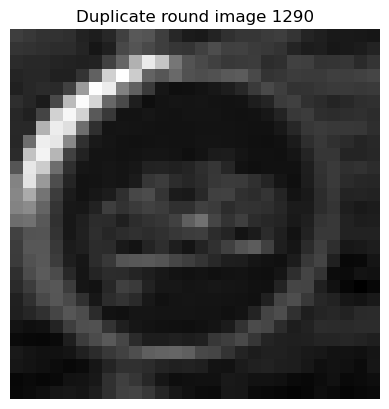

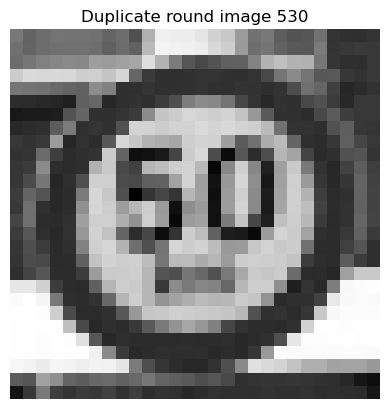

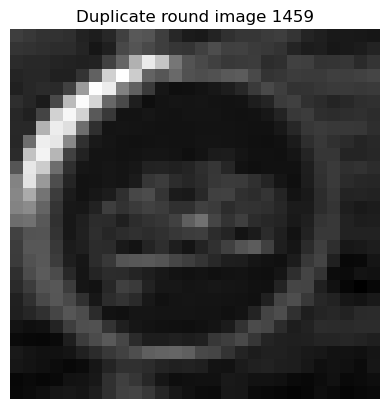

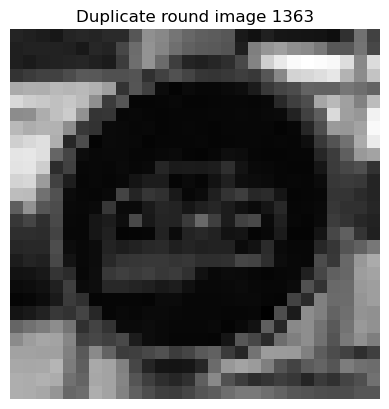

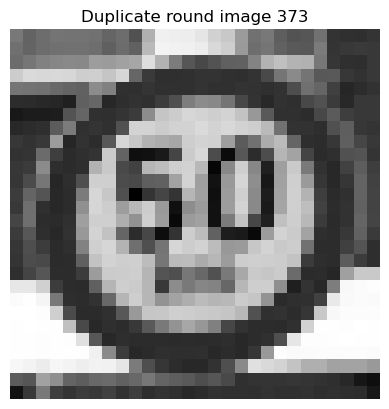

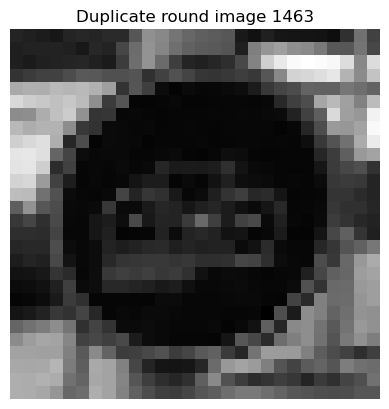

In [5]:
def visualize_duplicates(data, duplicates):
    for label, indices in duplicates.items():
        print(f"Duplicate images for label '{label}':")
        images = data[label]
        for idx in indices:
            img = images[idx]  # No need to convert to BGR for Matplotlib
            plt.imshow(img, cmap='gray')
            plt.title(f"Duplicate {label} image {idx}")
            plt.axis('off')
            plt.show()

# Visualize duplicates in original shape data
visualize_duplicates(org_shape_data, org_shape_duplicates)


### Removing Duplicate Images

In [6]:
def remove_duplicates(data, duplicates):
    for label, indices in duplicates.items():
        images = data[label]
        # Sort indices in descending order to remove from the end
        indices.sort(reverse=True)
        for idx in indices:
            del images[idx]

# Remove duplicates from original shape data
remove_duplicates(org_shape_data, org_shape_duplicates)


### 1.2.2 Visualizing Sample Images Side by Side

The display_sample_images_side_by_side function displays images from each class for both train and test data, showing them side by side. This visual comparison helps in verifying the consistency and quality of the data.

This visualization provides an easy way to inspect and compare the images from the original and collected datasets, ensuring that the images are correctly labeled and of similar quality.

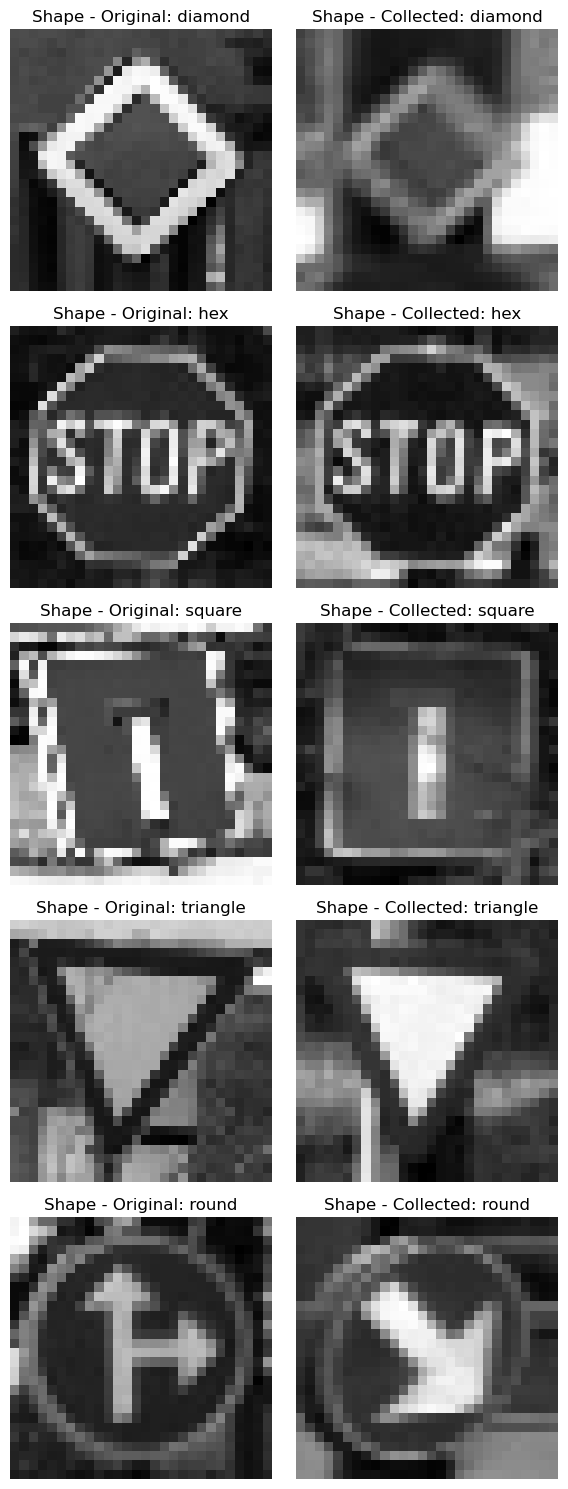

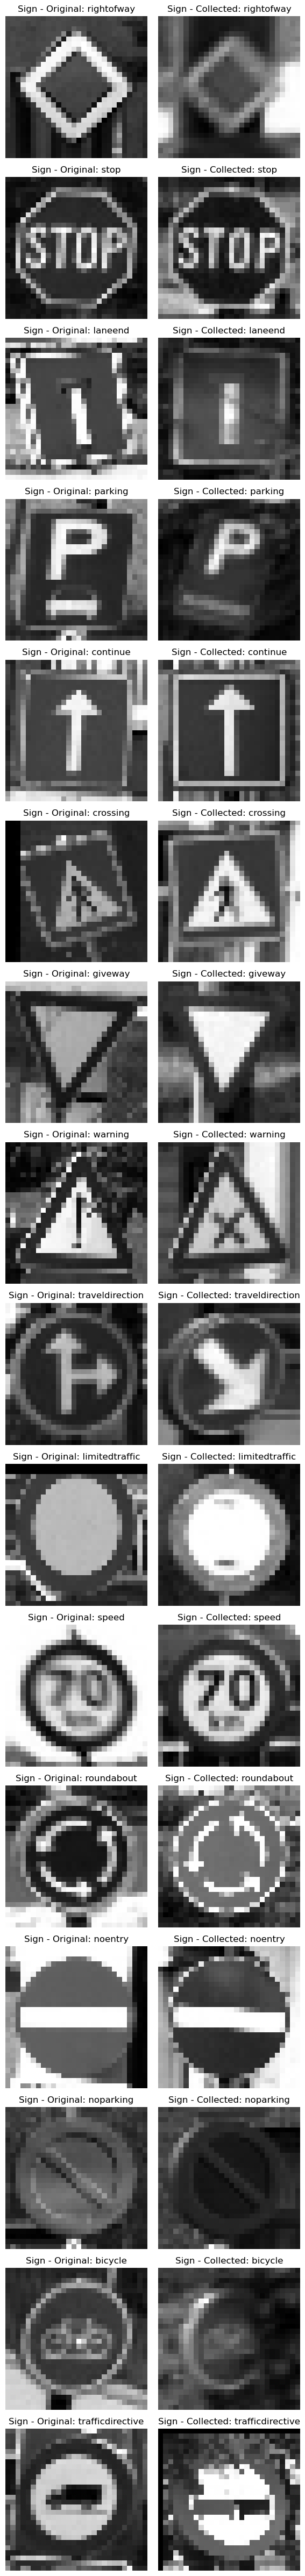

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Display images side by side from each class for both train and test data
def display_sample_images_side_by_side(train_data, test_data, title):
    num_categories = min(len(train_data), len(test_data))
    fig, axes = plt.subplots(num_categories, 2, figsize=(6, 3*num_categories))  # Decrease figure size
    for i, (label, train_images) in enumerate(train_data.items()):
        test_images = test_data[label]
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]
        ax1.imshow(np.array(train_images[0]), cmap='gray')
        ax1.set_title(f"{title} - Original: {label}")
        ax1.axis('off')
        ax2.imshow(np.array(test_images[0]), cmap='gray')
        ax2.set_title(f"{title} - Collected: {label}")
        ax2.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images side by side for shapes
display_sample_images_side_by_side(org_shape_data, collected_shape_data, "Shape")

# Display sample images side by side for signs
display_sample_images_side_by_side(org_sign_data, collected_sign_data, "Sign")


### 1.2.3 Analyzing the Distribution of Shape and Sign Classes

This section calculates and visualizes the distribution of samples across different shape and sign classes in the dataset. Bar plots are created to show the number of samples for each class, providing insights into the class distribution and identifying any potential imbalances.

These visualizations help in understanding the dataset composition and guide the need for data augmentation or re-sampling techniques to balance the classes.

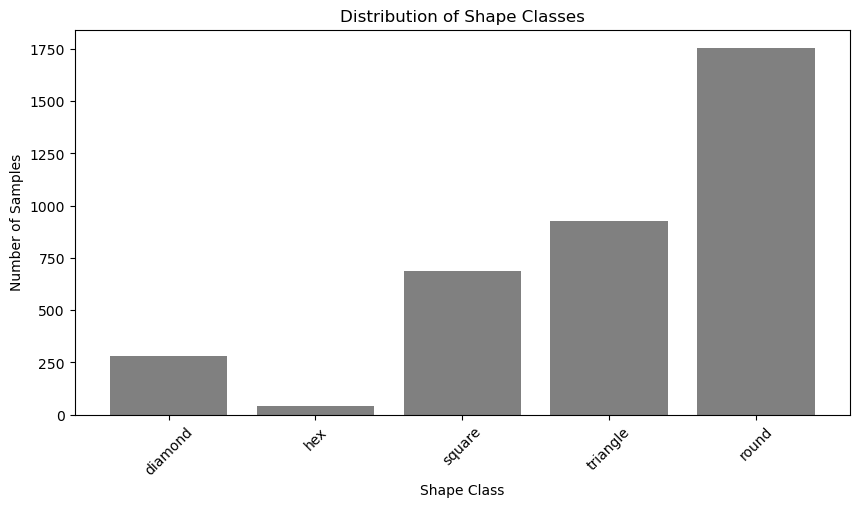

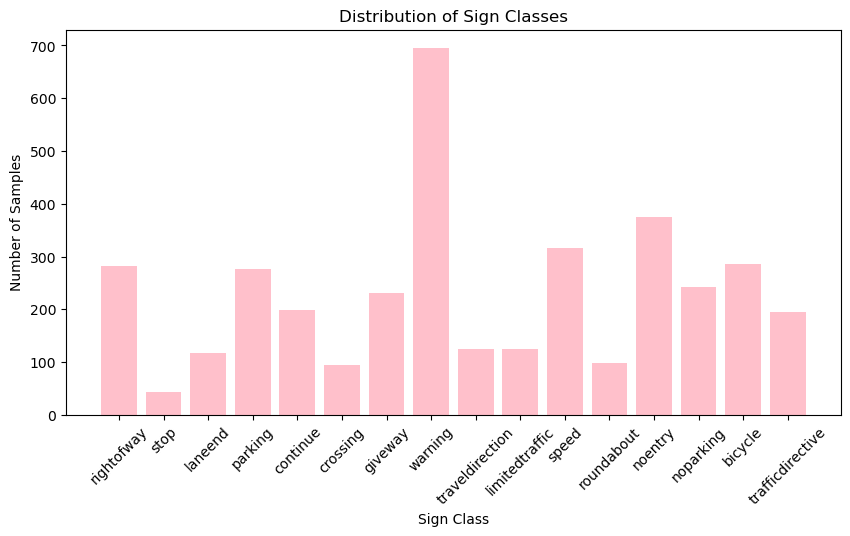

In [8]:
# Calculate the number of samples for each shape class
shape_class_counts = {label: len(images) for label, images in org_shape_data.items()}

# Calculate the number of samples for each sign class
sign_class_counts = {label: len(images) for label, images in org_sign_data.items()}

# Plot the distribution of shape classes
plt.figure(figsize=(10, 5))
plt.bar(shape_class_counts.keys(), shape_class_counts.values(), color='grey')
plt.xlabel('Shape Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Shape Classes')
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of sign classes
plt.figure(figsize=(10, 5))
plt.bar(sign_class_counts.keys(), sign_class_counts.values(), color='pink')
plt.xlabel('Sign Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Sign Classes')
plt.xticks(rotation=45)
plt.show()


### Identifying Class Imbalance in Shape and Sign Classes

The analysis reveals significant class imbalances in both shape and sign classes within the dataset. Notably, the "round" shape class exhibits a disproportionately large number of samples compared to other shape classes, while the "hex" shape class has a considerably smaller number of samples. Similarly, among sign classes, the "warning" sign class shows a substantially higher number of samples, whereas the "stop" sign class has notably fewer samples.

#### Implications:
- Class imbalances can lead to biased model predictions, where the model tends to favor classes with more samples.
- Addressing class imbalance is crucial to ensure fair and accurate model performance across all classes.
- Strategies such as data augmentation, re-sampling techniques, or using appropriate evaluation metrics can help mitigate the impact of class imbalance and improve model robustness.

### 1.2.4 Analyzing Pixel Value Statistics in Shape Dataset

The analysis focuses on computing statistics for pixel values within images belonging to the shape dataset. The statistics calculated include the mean, median, and variance of pixel values across all images.

- **Mean Pixel Value:** Represents the average pixel intensity across all images in the shape dataset.
- **Median Pixel Value:** Denotes the middle value of pixel intensities when all values are sorted.
- **Variance of Pixel Values:** Indicates the spread or dispersion of pixel intensities around the mean.

Understanding pixel value statistics is essential for assessing the overall characteristics and distribution of pixel intensities within image datasets, which can inform preprocessing steps and model design choices.

In [9]:
# Function to calculate statistics for pixel values within images
def calculate_statistics(images):
    pixel_values = np.concatenate(images)
    mean_pixel_value = np.mean(pixel_values)
    median_pixel_value = np.median(pixel_values)
    variance_pixel_value = np.var(pixel_values)
    return mean_pixel_value, median_pixel_value, variance_pixel_value

# Convert dictionary values to lists for statistics calculation
images = list(org_shape_data.values())

# Calculate statistics for shape data
mean, median, variance = calculate_statistics(images)

print("Statistics for given Dataset:")
print(f"Mean Pixel Value: {mean}")
print(f"Median Pixel Value: {median}")
print(f"Variance of Pixel Values: {variance}")

Statistics for given Dataset:
Mean Pixel Value: 98.67499184889228
Median Pixel Value: 77.0
Variance of Pixel Values: 4312.757697039149


**Based on these statistics:**

The mean pixel value indicates that, on average, the images in the shape data have a moderate intensity.
The median pixel value being lower than the mean suggests that the distribution of pixel intensities may be skewed towards lower values or that there may be some dark areas in the images.
The relatively high variance of pixel values indicates that there is a wide range of pixel intensities within the images, suggesting variability in brightness levels or texture across the dataset.

### 1.2.5 Plotting Pixel Intensity Histograms to Analyze Image Brightness and Color Distribution

Plotting histograms of pixel intensities for each category in original given data set. This visualization helps to understand the distribution of colors and brightness within the images. The histograms can reveal important characteristics about the images, such as whether they are generally darker or brighter.

Shape - Category: diamond


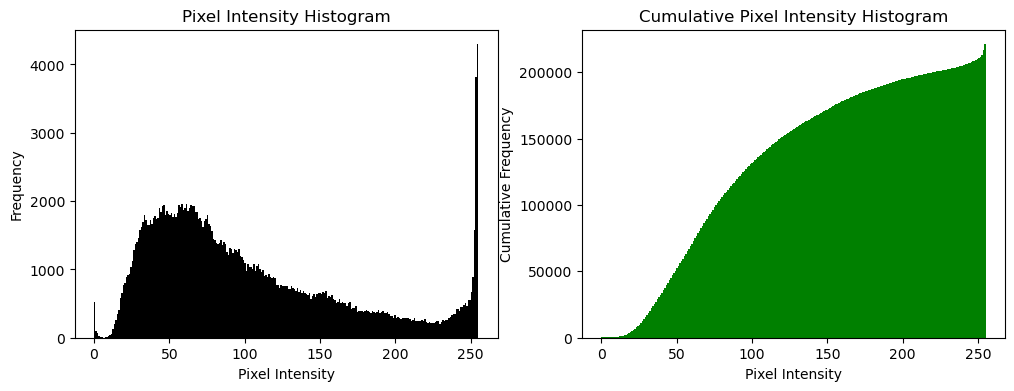

Shape - Category: hex


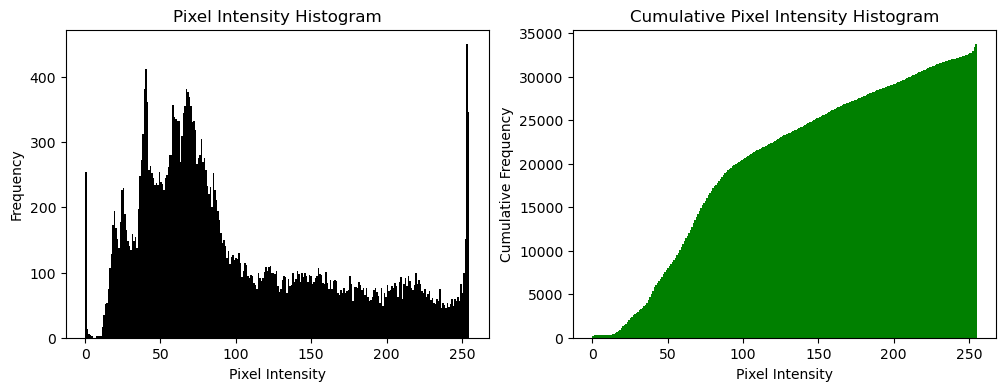

Shape - Category: square


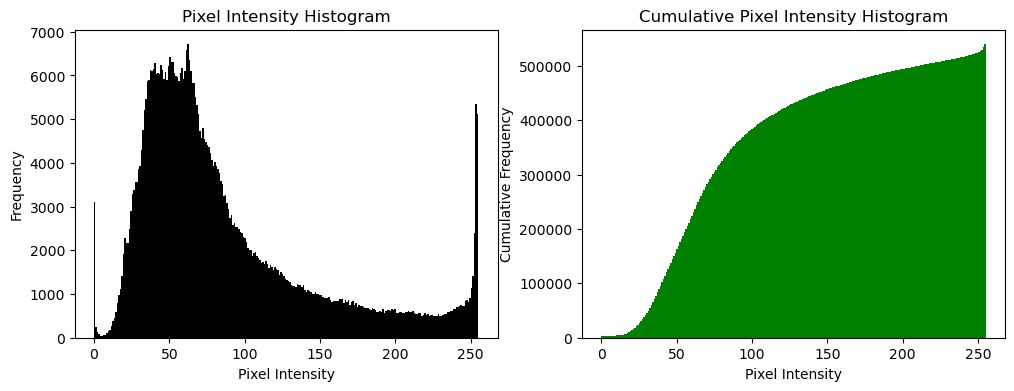

Shape - Category: triangle


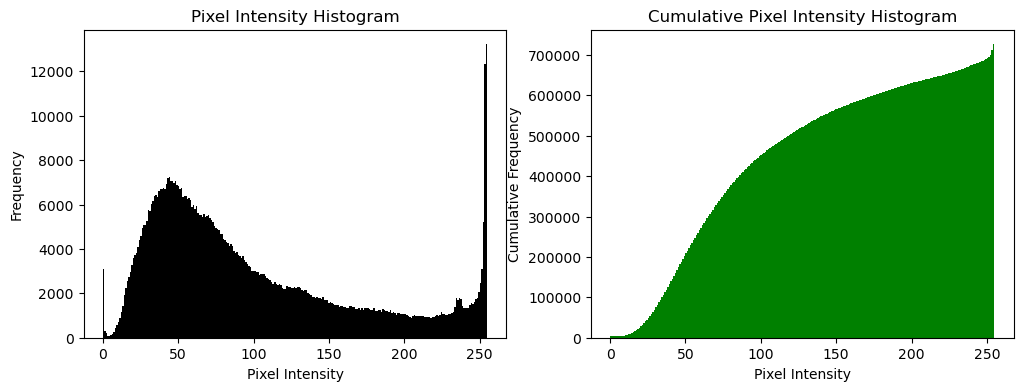

Shape - Category: round


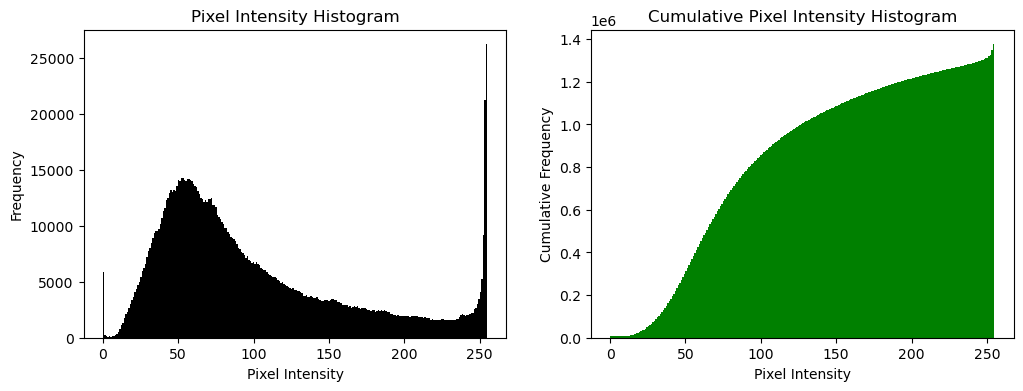

In [10]:
# Plot histograms of pixel intensities to understand distribution of colors and brightness
def plot_pixel_intensity_histograms(data, title):
    for label, images in data.items():
        print(f"{title} - Category: {label}")
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        # Flatten all images' pixel values
        flattened_pixels = np.concatenate(images).ravel()
        # Plot histogram
        axes[0].hist(flattened_pixels, bins=256, color='black')
        axes[0].set_title("Pixel Intensity Histogram")
        axes[0].set_xlabel("Pixel Intensity")
        axes[0].set_ylabel("Frequency")
        # Plot cumulative histogram
        axes[1].hist(flattened_pixels, bins=256, color='green', cumulative=True)
        axes[1].set_title("Cumulative Pixel Intensity Histogram")
        axes[1].set_xlabel("Pixel Intensity")
        axes[1].set_ylabel("Cumulative Frequency")
        plt.show()

plot_pixel_intensity_histograms(org_shape_data, "Shape")

**Observations from Histograms:**

The histograms generated by this code often show peaks towards the left side, indicating that most pixel values are lower, which corresponds to darker regions in the images. This observation can be crucial for understanding the overall brightness and color distribution within the data sets.

### 1.2.6 Edge Detection Analysis for Shape and Sign Images

The analysis involves performing edge detection using the Canny edge detector on sample images from both the shape and sign datasets. Edge detection is a fundamental image processing technique used to identify significant changes in pixel intensity, often corresponding to object boundaries or edges.

- Edge detection serves as a preprocessing step for extracting important features from images, crucial for subsequent tasks such as object detection and classification.
- The Canny edge detector is particularly adept at identifying edges while minimizing noise, making it suitable for various computer vision applications.

Shape - Category: diamond


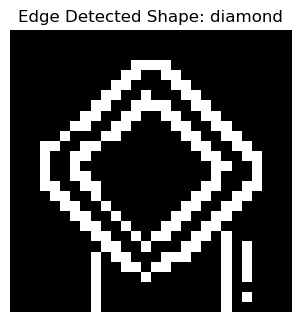

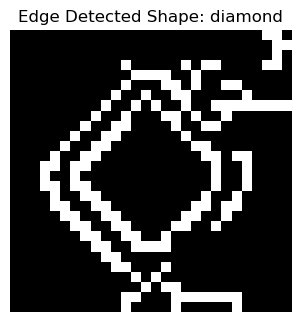

Shape - Category: hex


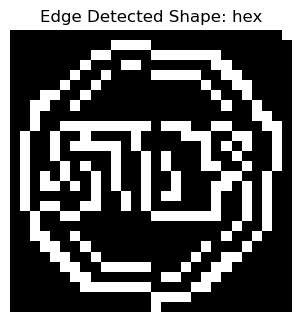

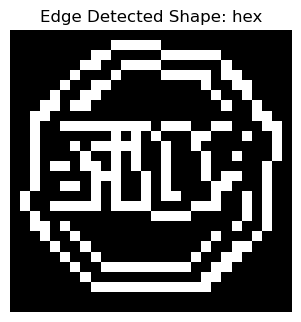

Shape - Category: square


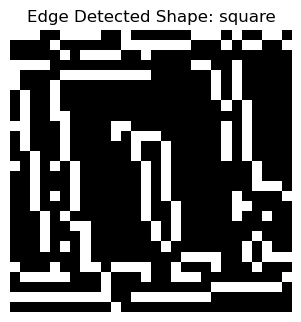

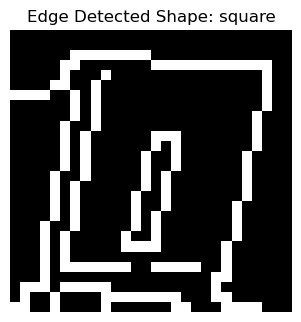

Shape - Category: triangle


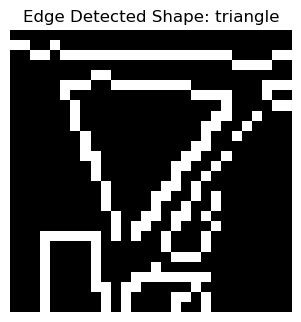

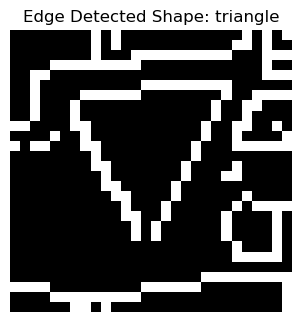

Shape - Category: round


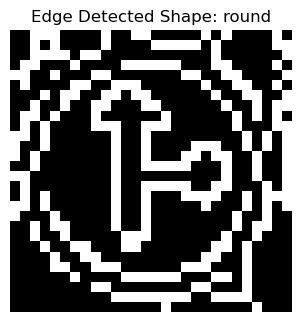

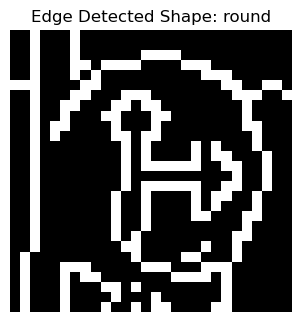

Sign - Category: rightofway


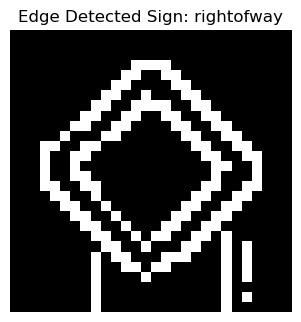

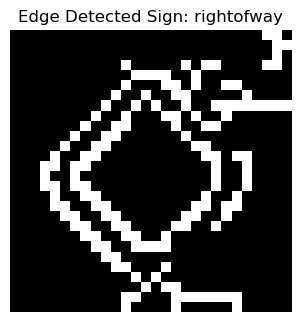

Sign - Category: stop


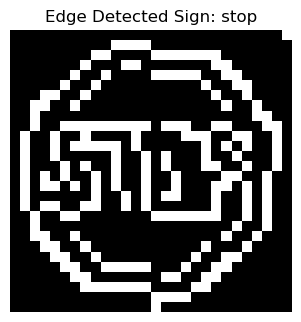

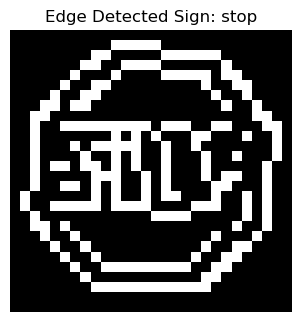

Sign - Category: laneend


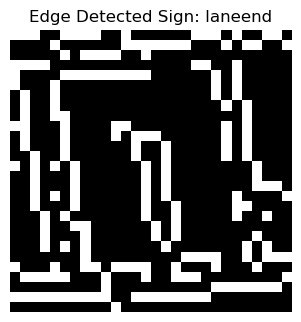

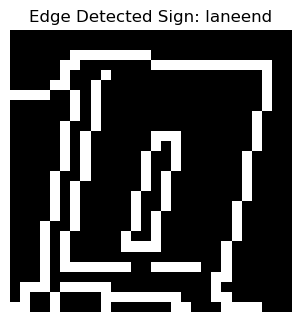

Sign - Category: parking


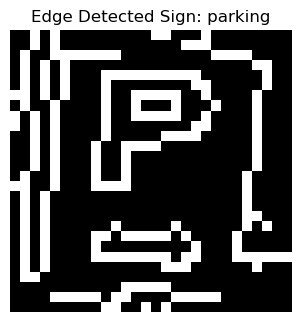

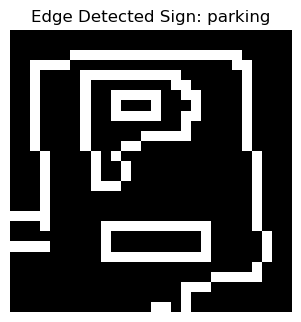

Sign - Category: continue


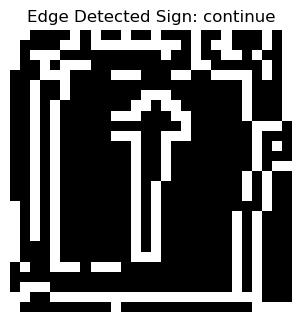

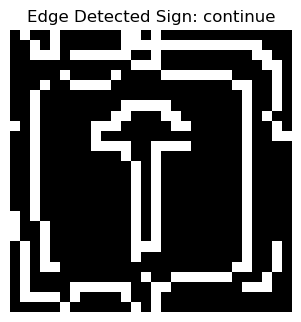

Sign - Category: crossing


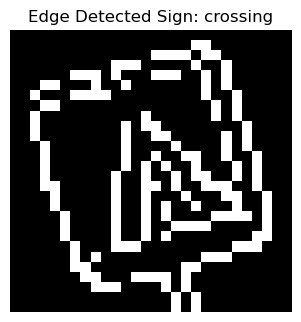

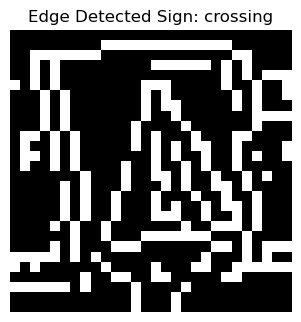

Sign - Category: giveway


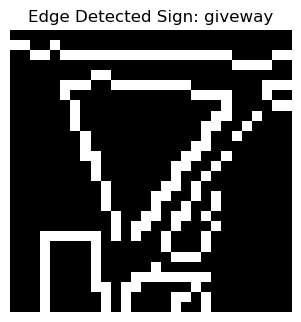

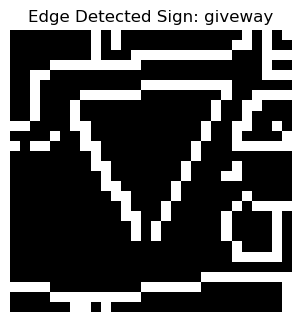

Sign - Category: warning


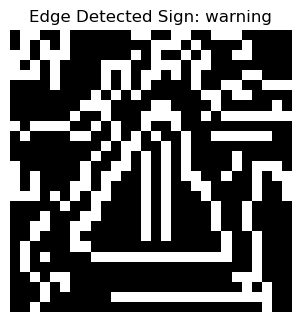

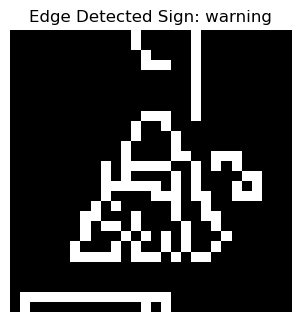

Sign - Category: traveldirection


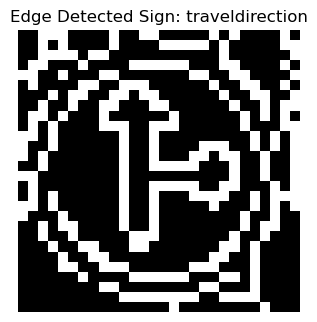

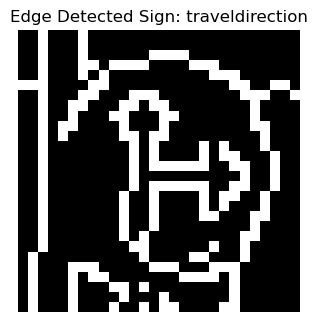

Sign - Category: limitedtraffic


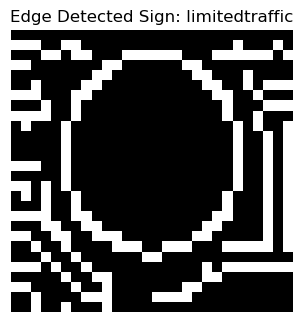

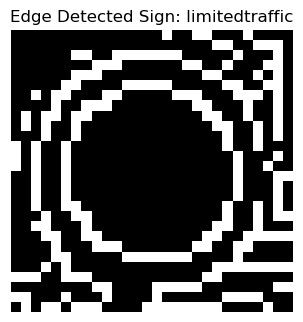

Sign - Category: speed


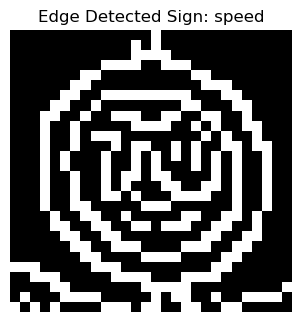

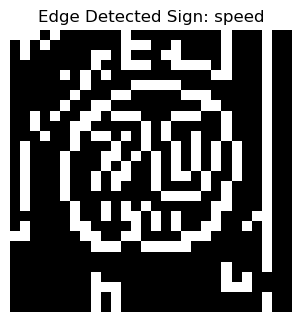

Sign - Category: roundabout


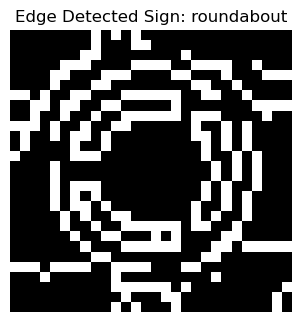

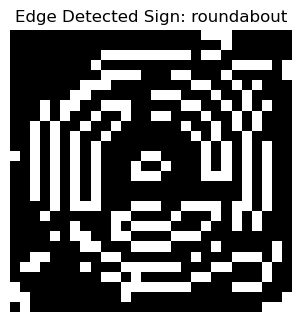

Sign - Category: noentry


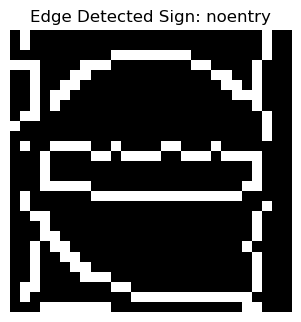

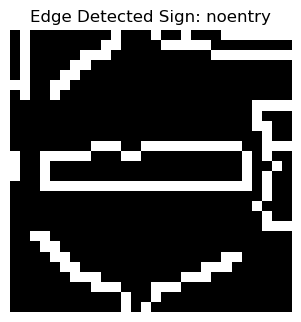

Sign - Category: noparking


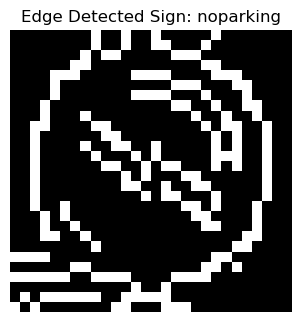

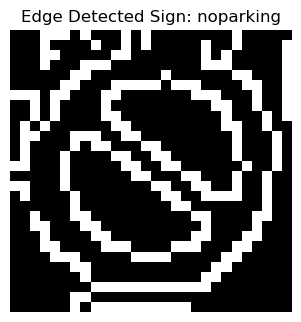

Sign - Category: bicycle


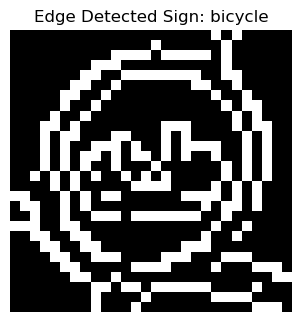

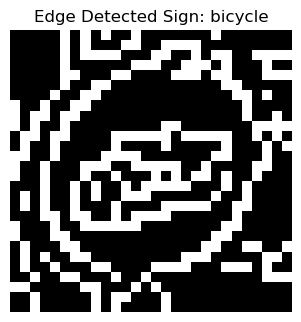

Sign - Category: trafficdirective


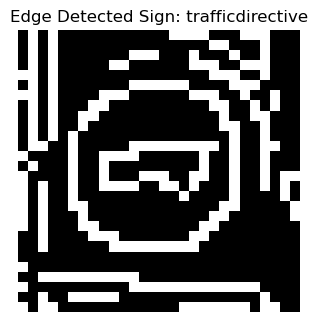

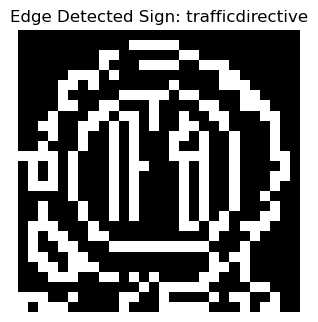

In [11]:
# Function to perform edge detection using Canny edge detector
def detect_edges(image):
    edges = cv2.Canny(image, 100, 200)  # Adjust thresholds as needed
    return edges


# Visualize edge detection results for sample images
def visualize_edge_detection(data, title):
    num_images_per_category = 2
    for label, images in data.items():
        print(f"{title} - Category: {label}")
        num_images = min(len(images), num_images_per_category)
        for i in range(num_images):
            plt.figure(figsize=(8, 4))
            plt.subplot(1, num_images, i+1)
            original_image = np.array(images[i])
            edge_image = detect_edges(original_image)
            plt.imshow(edge_image, cmap='gray')
            plt.title(f"Edge Detected {title}: {label}")
            plt.axis('off')
        plt.show()

visualize_edge_detection(org_shape_data, "Shape")
visualize_edge_detection(org_sign_data, "Sign")

# 2. Data Preprocessing

Data preprocessing is essential in machine learning to enhance data quality and model performance. It involves transforming raw data into a format that is suitable for analysis, often including steps like cleaning, normalization, scaling, and feature engineering. Proper preprocessing ensures that the data is in a form that the model can effectively learn from, leading to more accurate predictions and better generalization to unseen data.

### 2.1 Scaling Data

Data scaling is a crucial preprocessing step in machine learning, ensuring that features are on a similar scale. This process involves transforming feature values to fit within a specific range, typically between 0 and 1 or standardizing them to have a mean of 0 and a standard deviation of 1. Scaling prevents features with larger magnitudes from dominating the learning process and helps algorithms converge faster.

In [12]:
# Function to apply scaling to the data
def scale_data(data, batch_size=1):
    # Initialize ImageDataGenerator with rescale and data_format parameters
    datagen = ImageDataGenerator(
        rescale=1.0/255,  # Rescale pixel values to range [0, 1]
        data_format='channels_last'  # Image data format: channels_last
    )
    
    # Create a dictionary to store scaled data
    scaled_data = {}
    
    for label, images in data.items():
        images = np.expand_dims(images, axis=-1)  # Add channel dimension if it's missing
        generator = datagen.flow(images, batch_size=batch_size, shuffle=False)  # Set shuffle to False
        
        scaled_images = []
        num_batches = len(generator)
        for i in range(num_batches):
            batch = generator[i]
            scaled_images.extend(batch)
        
        scaled_data[label] = scaled_images
    
    return scaled_data

In [13]:
# Scale the data for shapes
org_shape_scaled_data = scale_data(org_shape_data)
collected_shape_test_data = scale_data(collected_shape_data)

# Scale the data for signs
org_sign_scaled_data = scale_data(org_sign_data)
collected_sign_test_data = scale_data(collected_sign_data)

### 2.1.1 Analyzing Pixel Value Statistics after Scaling

In [14]:
# Convert dictionary values to lists for statistics calculation
images = list(org_shape_scaled_data.values())

# Calculate statistics for shape data
mean, median, variance = calculate_statistics(images)

print("Statistics for given Dataset:")
print(f"Mean Pixel Value: {mean}")
print(f"Median Pixel Value: {median}")
print(f"Variance of Pixel Values: {variance}")

Statistics for given Dataset:
Mean Pixel Value: 0.3869609832763672
Median Pixel Value: 0.3019607961177826
Variance of Pixel Values: 0.0663246437907219


**After scaling the data, we calculate the statistical measures again to observe the changes:**
 
Mean Pixel Value: After scaling, the mean pixel value is 0.387, significantly lower than the original mean of 98.67. This change reflects the normalization of pixel values.
Median Pixel Value: The median pixel value after scaling is 0.302, also lower than the original median of 77.0, indicating a shift to the [0, 1] range.
Variance of Pixel Values: The variance is reduced to 0.066 from the original 4312.76, showing that the pixel values are now more tightly clustered around the mean due to normalization.
 
These statistics confirm that the scaling process has successfully normalized the pixel values, making them more suitable for training machine learning models

### 2.2 Data Splitting for Model Training and Evaluation : Train (70%), Validation (15%), Test (15%)
Data splitting is crucial for model training and evaluation to ensure that the model's performance generalizes well to unseen data. In our approach, we split the data into training, validation, and test sets using the `split_data` function. This function divides the data into three subsets, with a specified percentage allocated for validation and test data. The random state parameter ensures reproducibility across different runs.

In [15]:
def split_data(data, val_size=0.15, test_size=0.15, random_state=42):
    train_data = {}
    val_data = {}
    test_data = {}
    
    for label, images in data.items():
        # Split into remaining data and test set first
        remaining_images, test_images = train_test_split(images, test_size=test_size, random_state=random_state)
        
        # Then split the remaining data into training and validation sets
        remaining_size = 1 - test_size
        val_split = val_size / remaining_size
        train_images, val_images = train_test_split(remaining_images, test_size=val_split, random_state=random_state)
        
        train_data[label] = train_images
        val_data[label] = val_images
        test_data[label] = test_images
    
    return train_data, val_data, test_data

In [16]:

# Split the scaled data for shapes into training and validation sets
train_shape_data, val_shape_data, test_shape_data = split_data(org_shape_scaled_data)

# Split the scaled data for signs into training and validation sets
train_sign_data, val_sign_data, test_sign_data = split_data(org_sign_scaled_data)


### 2.2.1 Checking Data Distribution after Split:

The table represents the distribution of images across the training, validation, and test sets for various shapes and signs. The training set contains 70% of the data, the validation set contains 15%, and the test set contains the remaining 15%. Additionally, there's a column showing the count of images collected specifically for testing purposes.

In [17]:
from tabulate import tabulate

# Initialize tables for training, validation, and test sets for shapes and signs
shape_table = []
sign_table = []

# Add rows for training, validation, and test sets for shapes
for shape_label, train_images in train_shape_data.items():
    val_images = val_shape_data.get(shape_label, [])
    test_images = test_shape_data.get(shape_label, [])
    collected_test_images = collected_shape_test_data.get(shape_label, [])
    shape_table.append([f"{shape_label}", len(train_images), len(val_images), len(test_images),len(collected_test_images)])

# Add rows for training, validation, and test sets for signs
for sign_label, train_images in train_sign_data.items():
    val_images = val_sign_data.get(sign_label, [])
    test_images = test_sign_data.get(sign_label, [])
    collected_test_images = collected_sign_test_data.get(sign_label, [])
    sign_table.append([f"{sign_label}", len(train_images), len(val_images), len(test_images),len(collected_test_images)])

# Print the tables
print("Training, Validation, and Test Sets for Shapes:")
print(tabulate(shape_table, headers=["Set", "Train Images(70%)", "Validation Images(15%)", "Test Images(15%)", "Collected Test Images"]))
print("\nTraining, Validation, and Test Sets for Signs:")
print(tabulate(sign_table, headers=["Set","Train Images(70%)", "Validation Images(15%)", "Test Images(15%)", "Collected Test Images"]))


Training, Validation, and Test Sets for Shapes:
Set         Train Images(70%)    Validation Images(15%)    Test Images(15%)    Collected Test Images
--------  -------------------  ------------------------  ------------------  -----------------------
diamond                   196                        43                  43                       63
hex                        29                         7                   7                       36
square                    480                       104                 104                      157
triangle                  648                       139                 139                      574
round                    1227                       263                 264                      917

Training, Validation, and Test Sets for Signs:
Set                 Train Images(70%)    Validation Images(15%)    Test Images(15%)    Collected Test Images
----------------  -------------------  ------------------------  ------------------  ---

This distribution ensures a balanced representation of data across all sets, facilitating robust model training, validation, and evaluation. Additionally, the inclusion of collected test images allows for a comprehensive assessment of model performance

### 2.3 Converting Labels into numerical labels using One-Hot Encoding
The shape labels are converted into numerical labels and then subjected to one-hot encoding for both the shape and sign datasets. This process facilitates categorical representation for model training and evaluation.

In [18]:
# Convert the shape labels into numerical labels and perform one-hot encoding
label_to_index_shape = {label: i for i, label in enumerate(train_shape_data.keys())}
label_to_index_sign = {label: i for i, label in enumerate(train_sign_data.keys())}

y_train_shape_mlp = np.concatenate([np.full(len(images), label_to_index_shape[label]) for label, images in train_shape_data.items()])
y_train_sign_mlp = np.concatenate([np.full(len(images), label_to_index_sign[label]) for label, images in train_sign_data.items()])

y_val_shape_mlp = np.concatenate([np.full(len(images), label_to_index_shape[label]) for label, images in val_shape_data.items()])
y_val_sign_mlp = np.concatenate([np.full(len(images), label_to_index_sign[label]) for label, images in val_sign_data.items()])

y_test_shape_mlp = np.concatenate([np.full(len(images), label_to_index_shape[label]) for label, images in test_shape_data.items()])
y_test_sign_mlp = np.concatenate([np.full(len(images), label_to_index_sign[label]) for label, images in test_sign_data.items()])

y_test_shape_collected = np.concatenate([np.full(len(images), label_to_index_shape[label]) for label, images in collected_shape_test_data.items()])
y_test_sign_collected = np.concatenate([np.full(len(images), label_to_index_sign[label]) for label, images in collected_sign_test_data.items()])


# Perform one-hot encoding
num_classes_shape = len(label_to_index_shape)
num_classes_sign = len(label_to_index_sign)

y_train_shape = np.eye(num_classes_shape)[y_train_shape_mlp]
y_train_sign = np.eye(num_classes_sign)[y_train_sign_mlp]

y_val_shape = np.eye(num_classes_shape)[y_val_shape_mlp]
y_val_sign = np.eye(num_classes_sign)[y_val_sign_mlp]

y_test_shape = np.eye(num_classes_shape)[y_test_shape_mlp]
y_test_sign = np.eye(num_classes_sign)[y_test_sign_mlp]

y_test_shape_collected_one_hot = np.eye(num_classes_shape)[y_test_shape_collected]
y_test_sign_collected_one_hot = np.eye(num_classes_sign)[y_test_sign_collected]


### 2.3.1 Checking Encoded values for Shape type after One Hot Encoding

In [19]:
# Reverse the label_to_index_shape dictionary to obtain original shape labels
index_to_label_shape = {i: label for label, i in label_to_index_shape.items()}

# Initialize a set to keep track of seen shape labels
seen_labels = set()

# Verify one-hot encoded labels for each unique shape in y_train_shape_one_hot
for encoded_label in y_train_shape:
    # Find the index of the maximum value in the one-hot encoded label
    index = encoded_label.argmax()
    # Obtain the original shape label using the index
    original_label = index_to_label_shape[index]
    # Check if the shape label has been seen before
    if original_label not in seen_labels:
        print(f"Shape Label: {original_label}")
        print(f"One-hot Encoded Label: {encoded_label}")
        print()
        # Add the shape label to the set of seen labels
        seen_labels.add(original_label)


Shape Label: diamond
One-hot Encoded Label: [1. 0. 0. 0. 0.]

Shape Label: hex
One-hot Encoded Label: [0. 1. 0. 0. 0.]

Shape Label: square
One-hot Encoded Label: [0. 0. 1. 0. 0.]

Shape Label: triangle
One-hot Encoded Label: [0. 0. 0. 1. 0.]

Shape Label: round
One-hot Encoded Label: [0. 0. 0. 0. 1.]



# 3. Evaluation Utilities

## 3.1 Evaluation Dataframe
This DataFrame, `results_df`, serves as a structured way to store evaluation metrics for different models across various stages of evaluation. Each row represents a specific model's performance metrics, including accuracy, precision, recall, F1 score, and Cohen's Kappa, categorized by model name, type, evaluation stage, and model level.

In [20]:
results_df = pd.DataFrame(columns = ['Model Name','Type','EvaluationStage','Model Level', 'Accuracy', 'Precision', 'Recall', 'F1 Score', "Cohen's Kappa"])

## 3.2 Model Evaluation

The `evaluate_model` function is responsible for evaluating a given model using various performance metrics such as accuracy, precision, recall, and F1 score. Additionally, it calculates Cohen's Kappa and generates a confusion matrix to provide a comprehensive assessment of the model's performance.

### Function Parameters:
- `model`: The trained model to be evaluated.
- `X`: Input features for evaluation.
- `y`: True labels for evaluation.
- `model_name`: Name of the model being evaluated.

### Evaluation Metrics:
- **Accuracy**: The ratio of correctly predicted instances to the total instances.
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positive observations.
- **Recall**: The ratio of correctly predicted positive observations to the all observations in the actual class.
- **F1 Score**: The weighted average of Precision and Recall.
- **Cohen's Kappa**: A statistic that measures inter-rater agreement for categorical items.Cohen's Kappa is used to assess the agreement between the predicted labels and the true labels, taking into account the possibility of agreement occurring by chance. It provides a more robust evaluation of model performance, especially in scenarios where classes are imbalanced or when the accuracy metric alone may not be sufficient.

### Output:
- **Confusion Matrix**: A matrix showing the counts of true positive, true negative, false positive, and false negative predictions.

This function facilitates the evaluation of models and enables comparison of their performance across different metrics.

In [21]:
# Evaluate the model
def evaluate_model(model, X, y, model_name,model_type,model_EvaluationStage,model_level):
    global results_df 
    y_pred = model.predict(X, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y, axis=1)
    
    accuracy = round(accuracy_score(y_true_classes, y_pred_classes),4)
    precision = round(precision_score(y_true_classes, y_pred_classes, average='weighted'),4)
    recall = round(recall_score(y_true_classes, y_pred_classes, average='weighted'),4)
    f1 = round(f1_score(y_true_classes, y_pred_classes, average='weighted'),4)
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Calculate Cohen's Kappa
    kappa = round(cohen_kappa_score(y_true_classes, y_pred_classes),4)

    # Print evaluation metrics
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print("Cohen's Kappa: ", kappa)
    # Create result row as a DataFrame
    result_row = pd.DataFrame({'Model Name': [model_name], 
                               'Type':[model_type],
                               'EvaluationStage':[model_EvaluationStage],
                               'Model Level':[model_level],
                               'Accuracy': [accuracy], 
                               'Precision': [precision], 
                               'Recall': [recall], 
                               'F1 Score': [f1],
                               "Cohen's Kappa": [kappa]})

    # Concatenate existing DataFrame with new row DataFrame
    results_df = pd.concat([results_df, result_row], ignore_index=True)

    return cm

## 3.3 Confusion Matrix Visualization

The `visualise_cm` function is designed to visualize the confusion matrix generated during model evaluation. This visualization helps in understanding the performance of the model by providing insights into the distribution of true positive, true negative, false positive, and false negative predictions across different classes.

### Function Parameters:
- `cm`: Confusion matrix generated during model evaluation.
- `class_labels`: Labels representing different classes in the classification problem.

### Visualization:
- **Heatmap**: The confusion matrix is plotted as a heatmap using shades of blue to represent the counts in each cell.
- **Class Labels**: Class labels are displayed on both the x-axis and y-axis, representing the true and predicted labels respectively.
- **Annotation**: Each cell of the heatmap is annotated with the count of instances.

This visualization facilitates the interpretation of model performance by providing a clear representation of the distribution of predictions across different classes.

In [22]:

# Visualise the confusion matrix
def visualise_cm(cm, class_labels):
    # Plot confusion matrix heatmap with class labels
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = range(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    # Annotate each cell with the count
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, cm[i, j], horizontalalignment='center', verticalalignment='center')
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

## 3.4 Model Summary

The `model_summary` function prints a summary of the model architecture using the `summary` method available in Keras. Additionally, if provided, it prints the best values for model parameters.

This function aids in quickly inspecting the architecture of the model, including the number of parameters and the shape of each layer. It also provides insights into the best values for model hyperparameters if passed as input.

In [23]:
# Function to print Model Summary
def model_summary(model, params = None):
    print("Model Summary:\n")
    model.summary()

    if params != None:
        print("\nBest Values for Model Parameters:-")
        for param, value in params.items():
            print(f"{param} : {value}")

## 3.5 Learning Curve Plotting
This function, `plot_learning_curve`, creates a visualization of the learning curve during model training. It consists of two subplots: 

1. The left subplot displays the training and validation loss over epochs.
2. The right subplot displays the training and validation metric (e.g., accuracy, precision, recall, F1 score) over epochs.

These visualizations help assess the performance of the model during training, identify overfitting or underfitting, and determine whether further adjustments are needed.

In [24]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
 
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--', label='Train')
    plt.plot(val_loss, 'b--', label='Validation')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='upper left')
 
    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--', label='Train')
    plt.plot(val_metric, 'b--', label='Validation')
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.legend(loc='upper left')
 
    plt.show()

# 4. Baseline Model Creation (Model 1)

Baseline models serve as a fundamental starting point in machine learning projects, providing a reference for evaluating the performance of more complex models. They are typically simple, easy-to-implement models that capture basic patterns in the data without incorporating any advanced techniques

## 4.1 Baseline Model (Multilayer Perceptron)

Opting for a baseline MLP with two hidden layers aligns with my preference for simplicity, flexibility, efficiency, and reliance on historical success. It serves as a pragmatic starting point for shape and sign classification tasks, enabling systematic exploration of more sophisticated approaches while maintaining a solid foundation in traditional machine learning principles.

In [25]:
# Defining class labels
class_labels_shape = list(label_to_index_shape.keys()) 
class_labels_sign = list(label_to_index_sign.keys()) 

### 4.1.1 Flattening Images for MLP Model
Flattening the images converts them from 2D arrays to 1D arrays, making them suitable for input into a Multi-Layer Perceptron (MLP) model. This transformation allows each pixel in the image to be treated as a separate feature, enabling the MLP to learn patterns directly from the pixel values.

In [26]:
# Flatten the training data
X_train_shape_mlp = np.concatenate([np.array(images).reshape(len(images), -1) for images in train_shape_data.values()])
X_train_sign_mlp = np.concatenate([np.array(images).reshape(len(images), -1) for images in train_sign_data.values()])

# Flatten the validation data
X_val_shape_mlp = np.concatenate([np.array(images).reshape(len(images), -1) for images in val_shape_data.values()])
X_val_sign_mlp = np.concatenate([np.array(images).reshape(len(images), -1) for images in val_sign_data.values()])

# Flatten the test data
X_test_shape_mlp = np.concatenate([np.array(images).reshape(len(images), -1) for images in test_shape_data.values()])
X_test_sign_mlp = np.concatenate([np.array(images).reshape(len(images), -1) for images in test_sign_data.values()])

### 4.1.2 Verification of Flattening and One-Hot Encoding

In [27]:
# Verify flattening and one-hot encoding for shape data
print("X_train_shape_mlp shape:", X_train_shape_mlp.shape)  # Check the shape of the flattened images
print("y_train_shape_one_hot shape:", y_train_shape.shape)  # Check the shape of the one-hot encoded labels

# Verify flattening and one-hot encoding for sign data
print("X_train_sign_mlp shape:", X_train_sign_mlp.shape)  # Check the shape of the flattened images
print("y_train_sign_one_hot shape:", y_train_sign.shape)  # Check the shape of the one-hot encoded labels

X_train_shape_mlp shape: (2580, 784)
y_train_shape_one_hot shape: (2580, 5)
X_train_sign_mlp shape: (2573, 784)
y_train_sign_one_hot shape: (2573, 16)


## 4.2 MLP Model Creation
The `create_mlp_model` function is designed to create a Multi-Layer Perceptron (MLP) model for classification tasks. It defines a sequential model consisting of three dense layers. The architecture is as follows:

- **Input Layer**: The input layer has a dimension of `input_dim` (28x28), which corresponds to the number of features in the input data.
- **Hidden Layers**: There are two hidden layers with 128 and 64 neurons respectively. Both hidden layers use the sigmoid activation function.
- **Output Layer**: The output layer has `num_classes` neurons, representing the number of classes in the classification problem. It uses the softmax activation function to output class probabilities making it suitable for multi-class classification problems.

### Function Parameters:
- `num_classes`: Number of classes in the classification problem.
- `input_dim`: Dimensionality of the input data.

### Model Compilation:
- **Optimizer**: Stochastic Gradient Descent (SGD) optimizer is used.
- **Loss Function**: Categorical Cross-Entropy, suitable for multi-class classification.
- **Metrics**: Accuracy is tracked as a metric for evaluating model performance.

This function encapsulates the creation and compilation of a basic MLP model architecture, making it ready for training and prediction tasks.


In [28]:
def create_mlp_model(num_classes, input_dim, learning_rate=0.01):
    # Create the model
    model_mlp = Sequential([
            Dense(128, activation='sigmoid', input_shape=(input_dim,)),
            Dense(56, activation='sigmoid'),
            Dense(num_classes, activation='softmax')
            ])
    
    # Create SGD optimizer with a higher learning rate
    optimizer = SGD(learning_rate=learning_rate)

    # Compile the model with the new optimizer
    model_mlp.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['categorical_accuracy'])
    return model_mlp

## 4.2.1 Shape Data Model Training and Summary

This code block defines input dimensions and the number of classes for the shape classification task. It then creates an MLP model for shape classification using the `create_mlp_model` function, trains the model using the training data (`X_train_shape_mlp` and `y_train_shape`), and validates it using validation data (`X_val_shape_mlp` and `y_val_shape`). Finally, it prints a summary of the trained model using the `model_summary` function.

This process allows for the training and inspection of the model architecture, providing insights into its structure and the number of trainable parameters.

In [29]:
# Defining input dimensions and number of classes
input_dim_shape = X_train_shape_mlp.shape[1]

# Create the shape model
shape_model_mlp = create_mlp_model(num_classes_shape, input_dim_shape,0.1)

# Train the shape model
history_mlp_shape = shape_model_mlp.fit(X_train_shape_mlp, 
                        y_train_shape, 
                        epochs=10, 
                        batch_size=50, 
                        verbose=0, 
                        validation_data=(X_val_shape_mlp, y_val_shape))

#Print model summary
model_summary(shape_model_mlp)

Model Summary:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │         7,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,991 (421.84 KB)

 Trainable params: 107,989 (421.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

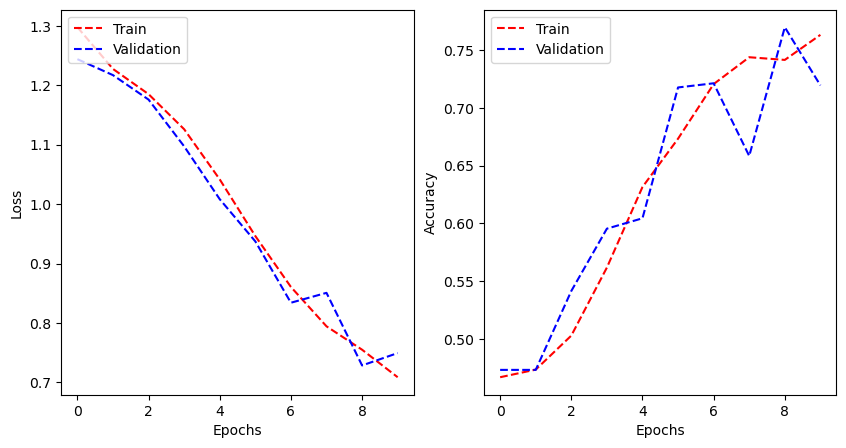

In [30]:
# Plot learning curves using the custom function
plot_learning_curve(history_mlp_shape.history['loss'], history_mlp_shape.history['val_loss'],
                    history_mlp_shape.history['categorical_accuracy'], history_mlp_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [31]:
# Evaluate the model using validation data
print("Performace Metrics of MLP Model for Shape on Validation data:-")
shape_cm_mlp_val = evaluate_model(shape_model_mlp, X_val_shape_mlp, y_val_shape,"MLP Baseline",'Shape','Validation',1);

Performace Metrics of MLP Model for Shape on Validation data:-
Accuracy:  0.7194
Precision:  0.6961
Recall:  0.7194
F1 Score:  0.6694
Cohen's Kappa:  0.5289


### Model Evaluation and Confusion Matrix of MLP Model for Shape

Performace Metrics of MLP Model for Shape on Test data:-
Accuracy:  0.7415
Precision:  0.719
Recall:  0.7415
F1 Score:  0.6836
Cohen's Kappa:  0.5673


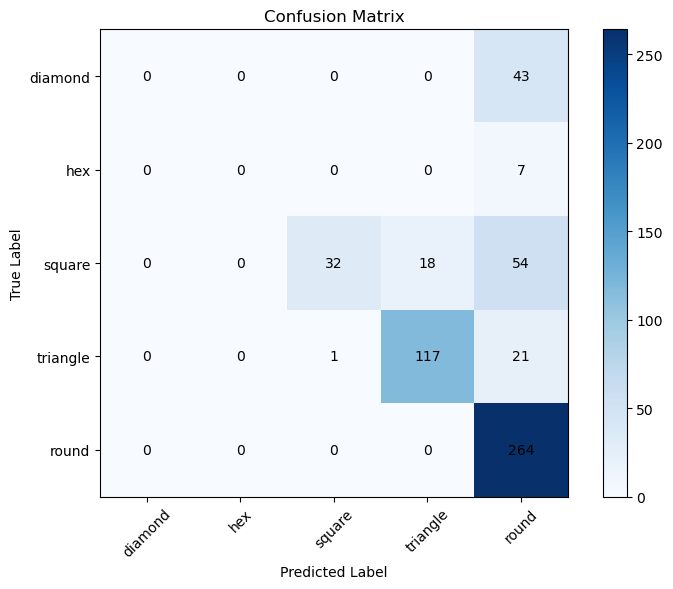

In [32]:
# Evaluate the model using test data
print("Performace Metrics of MLP Model for Shape on Test data:-")
shape_cm_mlp_test = evaluate_model(shape_model_mlp, X_test_shape_mlp, y_test_shape,"MLP Baseline","Shape","Test",1);

# Visualise Confusion matrix
visualise_cm(shape_cm_mlp_test, class_labels_shape)

## 4.2.2 Sign Data Model Training and Summary

This code block defines the input dimensions and the number of classes for the sign classification task. It then creates an MLP model for sign classification using the `create_mlp_model` function. The model is trained using the training data (`X_train_sign_mlp` and `y_train_sign`) and validated using the validation data (`X_val_sign_mlp` and `y_val_sign`). Finally, it prints a summary of the trained model using the `model_summary` function.

This process enables the training and validation of a model specifically designed for sign classification and provides insights into the model's architecture and parameters.

In [33]:
# Defining input dimensions and number of classes for sign data
input_dim_sign = X_train_sign_mlp.shape[1]

# Create the sign model
sign_model_mlp = create_mlp_model(num_classes_sign, input_dim_sign)

# Train the sign model
history_mlp_sign= sign_model_mlp.fit(X_train_sign_mlp, 
                       y_train_sign, 
                       epochs=10, 
                       batch_size=50, 
                       verbose=0, 
                       validation_data=(X_val_sign_mlp, y_val_sign))

#Print model summary
model_summary(shape_model_mlp)


Model Summary:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │         7,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,991 (421.84 KB)

 Trainable params: 107,989 (421.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

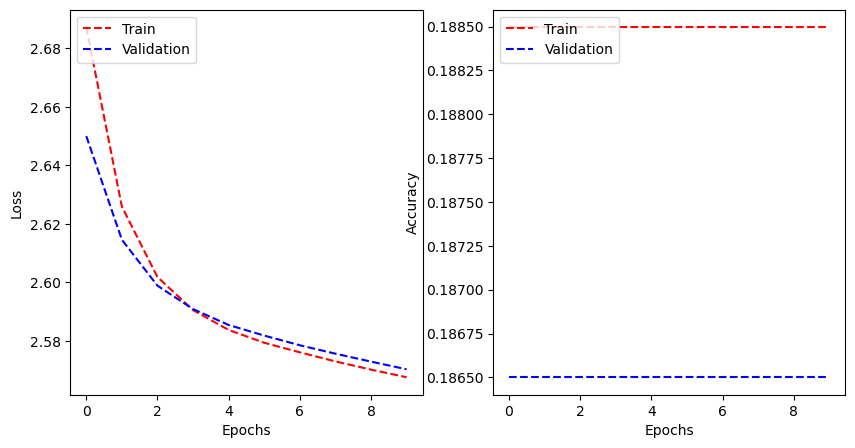

In [34]:
# Plot learning curves using the custom function
plot_learning_curve(history_mlp_sign.history['loss'], history_mlp_sign.history['val_loss'],
                    history_mlp_sign.history['categorical_accuracy'], history_mlp_sign.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [35]:
# Evaluate the model using validation data
print("Performace Metrics of MLP Model for Sign on Validation data:-")
sign_cm_mlp_val = evaluate_model(sign_model_mlp, X_val_sign_mlp, y_val_sign,"MLP Baseline","Sign","Validation",1)

Performace Metrics of MLP Model for Sign on Validation data:-
Accuracy:  0.1865
Precision:  0.0348
Recall:  0.1865
F1 Score:  0.0586
Cohen's Kappa:  0.0


In [36]:
# Evaluate the model using test data
print("Performace Metrics of MLP Model for Sign on Test data:-")
sign_cm_mlp_test = evaluate_model(sign_model_mlp, X_test_sign_mlp, y_test_sign,"MLP Baseline","Sign","Test",1);

Performace Metrics of MLP Model for Sign on Test data:-
Accuracy:  0.1865
Precision:  0.0348
Recall:  0.1865
F1 Score:  0.0586
Cohen's Kappa:  0.0


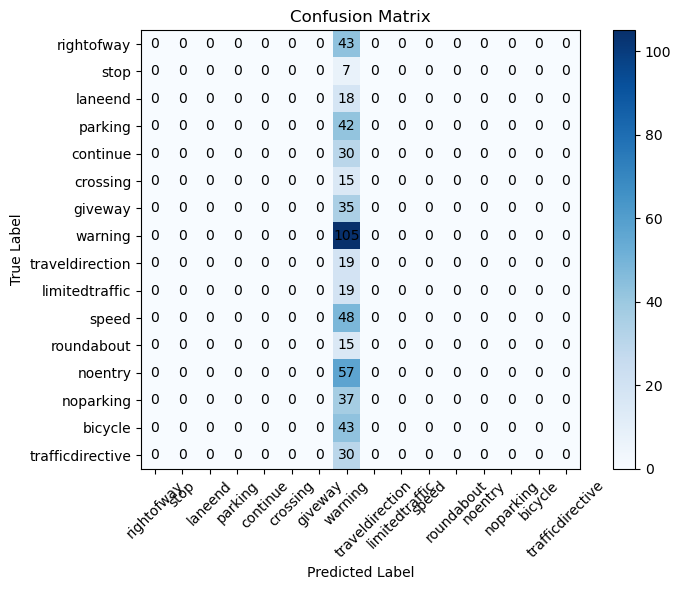

In [37]:
# Visualise Confusion matrix
visualise_cm(sign_cm_mlp_test, class_labels_sign)

# 5. Improved Model

## Improved Classification Model :  Convolutional Neural Network

A Convolutional Neural Network (CNN) is a deep learning algorithm designed to analyze visual data. It employs a hierarchical architecture that learns to extract features from images through convolutional layers. CNNs are particularly effective for tasks like image classification, object detection, and image segmentation due to their ability to automatically learn spatial hierarchies of features from raw pixel values.

### Why the CNN Model is Suitable for Shape and Sign Traffic Signal Data?
The CNN model created by the create_cnn_model function is highly suitable for shape and sign traffic signal data due to its powerful feature extraction capabilities, robustness to variations in image data, ability to prevent overfitting, and flexibility in configuration. These attributes make it an ideal choice for achieving high accuracy in traffic signal classification tasks
- `Spatial Hierarchies`: CNNs are excellent at capturing spatial hierarchies in images, which means they can detect edges, textures, shapes, and more complex patterns. This is essential for accurately identifying different traffic signs and shapes that have unique visual characteristics.
- `Automatic Learning`: Unlike traditional methods that require manual feature extraction, CNNs automatically learn the most relevant features directly from the pixel data.

### Preparation of Training, Validation, and Testing Data
Preparing the datasets for training, validation, and testing for both shape and sign classification tasks. It consolidates the image data into respective arrays.

In [38]:
# Prepare training, validation and testing data for Shape
X_train_shape_cnn = np.concatenate([np.array(images) for images in train_shape_data.values()])
X_val_shape_cnn = np.concatenate([np.array(images) for images in val_shape_data.values()])
X_test_shape_cnn = np.concatenate([np.array(images) for images in test_shape_data.values()])
X_test_shape_collected = np.concatenate([np.array(images) for images in collected_shape_test_data.values()])

# Prepare training,validation and testing data for Sign
X_train_sign_cnn = np.concatenate([np.array(images) for images in train_sign_data.values()])
X_val_sign_cnn = np.concatenate([np.array(images) for images in val_sign_data.values()])
X_test_sign_cnn = np.concatenate([np.array(images) for images in test_sign_data.values()])
X_test_sign_collected = np.concatenate([np.array(images) for images in collected_sign_test_data.values()])

## 5.1 Basic CNN Model Creation: Basic Architecture ( Model 2)
This function `create_cnn_basic_model` constructs a basic Convolutional Neural Network (CNN) model for image classification tasks, suitable for shape and sign recognition. It consists of multiple layers arranged sequentially:

1. **Convolutional Layers**: Three convolutional layers with increasing filter sizes (32, 64, and 128) and kernel size (3x3). These layers learn spatial hierarchies of features in the input images.
   
2. **Pooling Layers**: After each convolutional layer, a max-pooling layer with a pool size of (2, 2) is added. This layer reduces the spatial dimensions of the feature maps, aiding in translation invariance and reducing computational complexity.

3. **Flatten Layer**: This layer flattens the output from the previous layers into a one-dimensional vector, preparing it for input to the fully connected layers.

4. **Fully Connected Layers**: Two dense (fully connected) layers follow the flattened output. The first dense layer consists of 128 neurons and uses the specified activation function. The final layer, with the number of neurons equal to the number of classes, employs the softmax activation function to output class probabilities.

By customizing activation functions and optimizers, this model offers flexibility to adapt to different classification tasks. It is compiled using categorical cross-entropy loss, suitable for multi-class classification, and categorical accuracy as the evaluation metric.

In [39]:
# Create CNN model
def create_cnn_basic_model(num_classes, activation='sigmoid', optimizer='SGD'):
    model = Sequential([
            Conv2D(32, kernel_size=(3, 3), activation=activation, input_shape=(28, 28, 1)), #images are grayscale with shape 28x28
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, kernel_size=(3, 3), activation=activation),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, kernel_size=(3, 3), activation=activation),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation=activation),
            Dense(num_classes, activation='softmax')  # Output layer with num_classes units
            ])
        
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    return model

### 5.1.1 Basic CNN for Shape

In [40]:
# Create CNN model
shape_model_cnn_basic = create_cnn_basic_model(num_classes_shape)

#Print model summary
model_summary(shape_model_cnn_basic)

# Train the model 
history_cnn_basic_shape = shape_model_cnn_basic.fit(X_train_shape_cnn,
                    y_train_shape,
                    epochs=10, batch_size=30, 
                    verbose=0, 
                    validation_data=(X_val_shape_cnn, y_val_shape))

Model Summary:



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,829 (429.02 KB)

 Trainable params: 109,829 (429.02 KB)

 Non-trainable params: 0 (0.00 B)

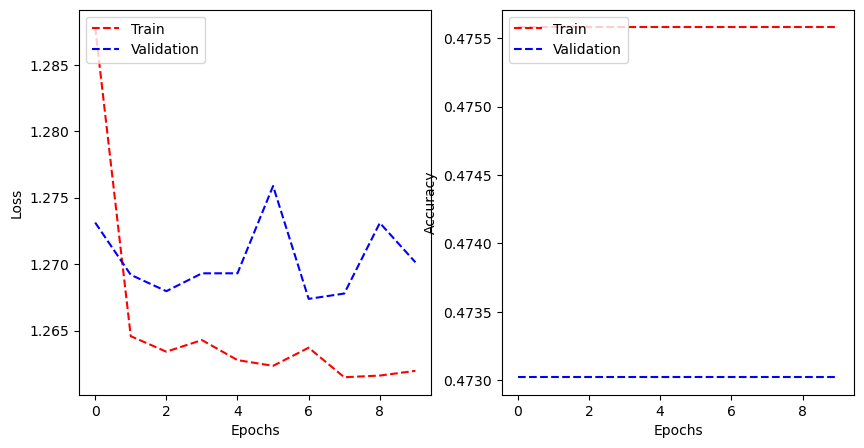

In [41]:
# Plot learning curves using the custom function
plot_learning_curve(history_cnn_basic_shape.history['loss'], history_cnn_basic_shape.history['val_loss'],
                    history_cnn_basic_shape.history['categorical_accuracy'], history_cnn_basic_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [42]:
# Evaluate the shape model on validation data
print("Performace Metrics of Basic CNN Model for Shape on Validation data:-")
shape_cm_cnn_val = evaluate_model(shape_model_cnn_basic, X_val_shape_cnn, y_val_shape,"CNN Model 1","Shape","Validation",2);

Performace Metrics of Basic CNN Model for Shape on Validation data:-
Accuracy:  0.473
Precision:  0.2237
Recall:  0.473
F1 Score:  0.3038
Cohen's Kappa:  0.0


Performace Metrics of Basic CNN Model for Shape on Test data:-
Accuracy:  0.474
Precision:  0.2246
Recall:  0.474
F1 Score:  0.3048
Cohen's Kappa:  0.0


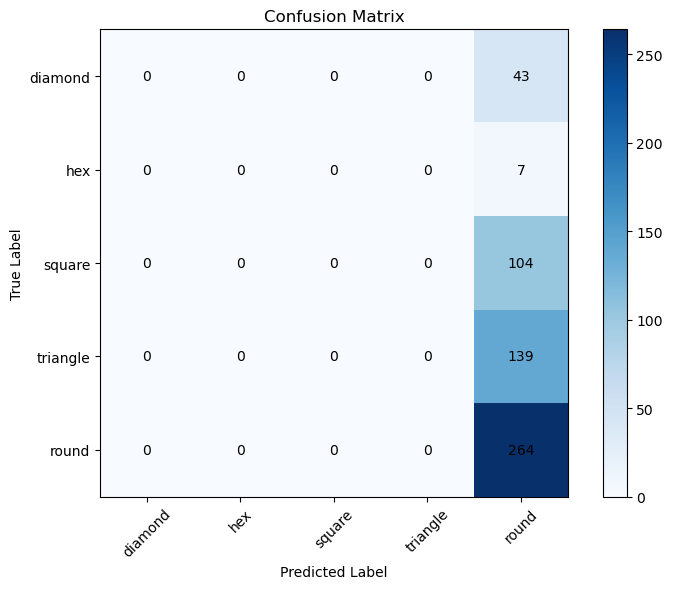

In [43]:
# Evaluate the shape model on test data
print("Performace Metrics of Basic CNN Model for Shape on Test data:-")
shape_cm_cnn_test = evaluate_model(shape_model_cnn_basic, X_test_shape_cnn, y_test_shape,"CNN Model 1","Shape","Test",2);

# Visualise Confusion matrix
visualise_cm(shape_cm_cnn_test, class_labels_shape)

### 5.1.2 Baisc CNN for Sign

In [44]:
# Create CNN model
sign_model_basic_cnn = create_cnn_basic_model(num_classes_sign)

#Print model summary
model_summary(sign_model_basic_cnn)

# Train the model 
history_sign_basic_cnn= sign_model_basic_cnn.fit(X_train_sign_cnn, 
                   y_train_sign, 
                   epochs=10, 
                   batch_size=30, 
                   verbose=0,
                   validation_data=(X_val_sign_cnn, y_val_sign))

Model Summary:



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,248 (434.56 KB)

 Trainable params: 111,248 (434.56 KB)

 Non-trainable params: 0 (0.00 B)

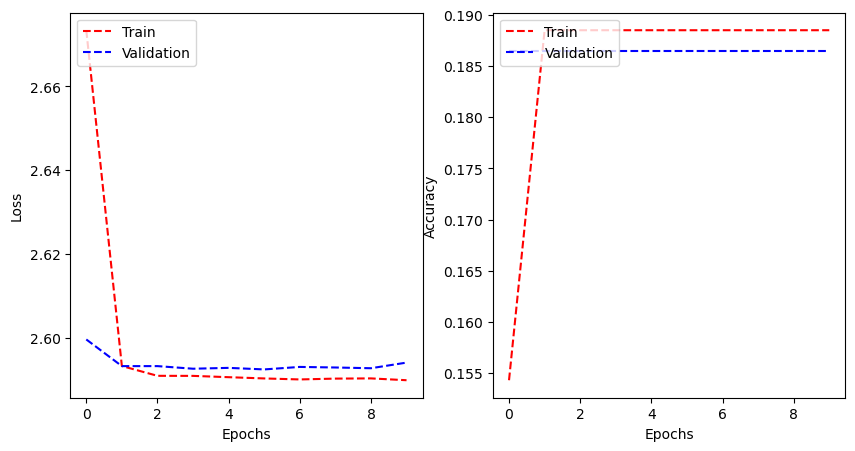

In [45]:
# Plot learning curves using the custom function
plot_learning_curve(history_sign_basic_cnn.history['loss'], history_sign_basic_cnn.history['val_loss'],
                    history_sign_basic_cnn.history['categorical_accuracy'], history_sign_basic_cnn.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [46]:
# Evaluate the sign model on validation data
print("Performace Metrics of Basic CNN Model for Sign on Validation data:-")
sign_cm_cnn_val = evaluate_model(sign_model_basic_cnn, X_val_sign_cnn, y_val_sign,"CNN Model 1","Sign","Validation",2);

Performace Metrics of Basic CNN Model for Sign on Validation data:-
Accuracy:  0.1865
Precision:  0.0348
Recall:  0.1865
F1 Score:  0.0586
Cohen's Kappa:  0.0


Performace Metrics of Basic CNN Model for Sign on Test data:-
Accuracy:  0.1865
Precision:  0.0348
Recall:  0.1865
F1 Score:  0.0586
Cohen's Kappa:  0.0


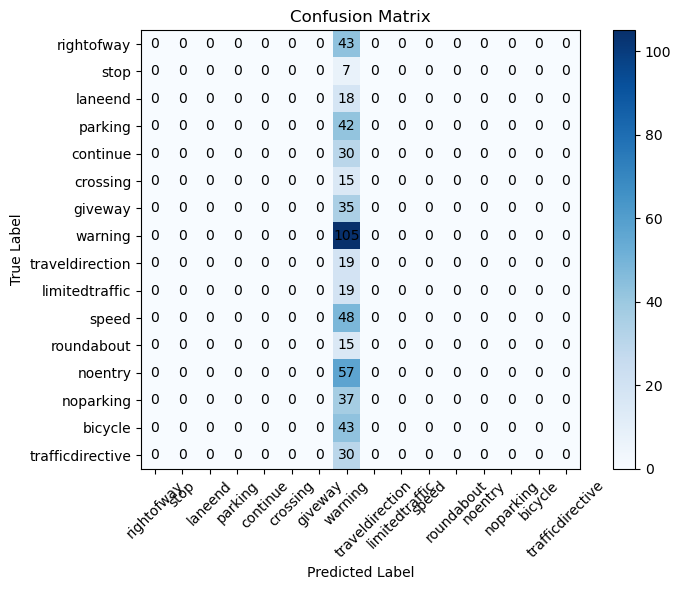

In [47]:
# Evaluate the sign model on test data
print("Performace Metrics of Basic CNN Model for Sign on Test data:-")
sign_cm_cnn_test = evaluate_model(sign_model_basic_cnn, X_test_sign_cnn, y_test_sign,"CNN Model 1","Sign","Test",2);

# Visualise Confusion matrix
visualise_cm(sign_cm_cnn_test, class_labels_sign)

## 5.2 Adding Batch Normalization to Improve Model Performance (Model 3)

To enhance the performance and stability of our CNN model, we have integrated batch normalization into the network architecture. Batch normalization normalizes the inputs to each layer, reducing internal covariate shift, improving gradient flow, and allowing for higher learning rates. This adjustment has led to significant improvements in training efficiency and model accuracy.

Here is the updated function for creating a CNN model with batch normalization:

In [48]:
# Function to create basic CNN model 
def create_cnn_model_normalised(num_classes, activation='sigmoid', optimizer='SGD', dropout_rate=0.2, num_layers=3, layer_size=64, use_bias=True,learning_rate=0.1):
    model = Sequential([
                    Input(shape=(28, 28, 1)),
                    Conv2D(32, kernel_size=(3, 3), activation=None),
                    BatchNormalization(), 
                    Activation(activation),
                    MaxPooling2D(pool_size=(2, 2))
                    ])
    
    for _ in range(num_layers - 1):
        model.add(Conv2D(layer_size, kernel_size=(3, 3), activation=None, use_bias=use_bias))
        model.add(BatchNormalization())
        Activation(activation),
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(Flatten())
    # Add dropout
    model.add(Dropout(dropout_rate))
    
    # Add fully connected layers
    model.add(Dense(128, activation=activation, use_bias=use_bias))
    model.add(Dense(num_classes, activation='softmax', use_bias=use_bias))  

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### 5.2.1 Basic CNN for Shape with batch normalisation

In [49]:
# Create CNN model
shape_model_cnn_normalised = create_cnn_model_normalised(num_classes_shape)

#Print model summary
model_summary(shape_model_cnn_normalised)

# Train the model 
history_cnn_basic_shape_normalised = shape_model_cnn_normalised.fit(X_train_shape_cnn,
                    y_train_shape,
                    epochs=10, batch_size=30, 
                    verbose=0, 
                    validation_data=(X_val_shape_cnn, y_val_shape))

Model Summary:



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,349 (255.27 KB)

 Trainable params: 65,029 (254.02 KB)

 Non-trainable params: 320 (1.25 KB)

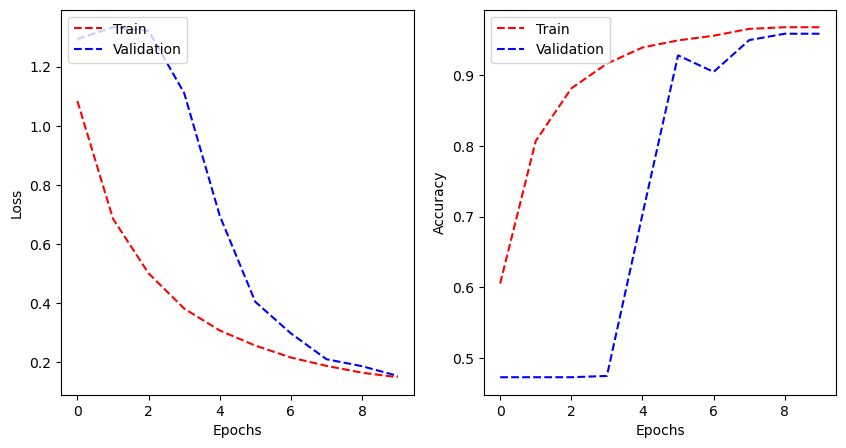

In [50]:
# Plot learning curves using the custom function
plot_learning_curve(history_cnn_basic_shape_normalised.history['loss'], history_cnn_basic_shape_normalised.history['val_loss'],
                    history_cnn_basic_shape_normalised.history['accuracy'], history_cnn_basic_shape_normalised.history['val_accuracy'],
                    metric_name='Accuracy')

In [51]:
# Evaluate the shape model on validation data
print("Performace Metrics of Basic CNN Model with Batch Normalisation for Shape on Validation data:-")
shape_cm_cnn_val = evaluate_model(shape_model_cnn_normalised, X_val_shape_cnn, y_val_shape,"CNN Model 2","Shape","Validation",3);

Performace Metrics of Basic CNN Model with Batch Normalisation for Shape on Validation data:-
Accuracy:  0.9586
Precision:  0.9603
Recall:  0.9586
F1 Score:  0.9546
Cohen's Kappa:  0.9377


Performace Metrics of Basic CNN Model with Batch Normalisation for Shape on Test data:-
Accuracy:  0.9587
Precision:  0.948
Recall:  0.9587
F1 Score:  0.9525
Cohen's Kappa:  0.9375


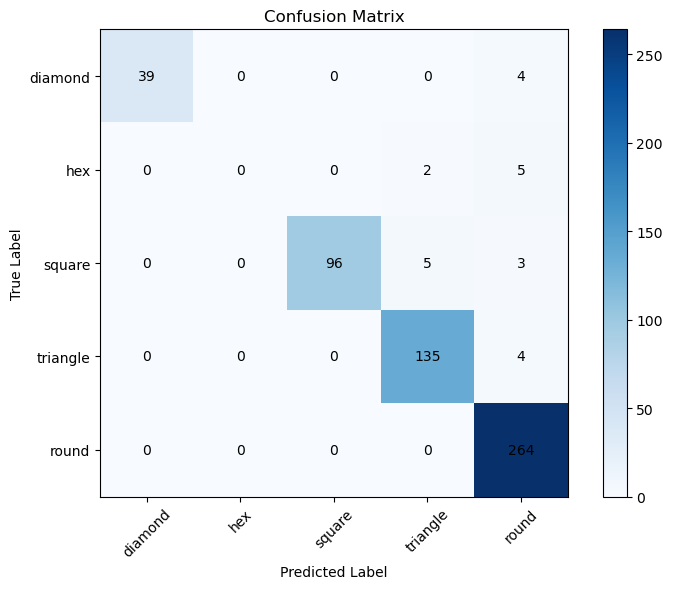

In [52]:
# Evaluate the shape model on test data
print("Performace Metrics of Basic CNN Model with Batch Normalisation for Shape on Test data:-")
shape_cm_cnn_test = evaluate_model(shape_model_cnn_normalised, X_test_shape_cnn, y_test_shape,"CNN Model 2","Shape","Test",3);

# Visualise Confusion matrix
visualise_cm(shape_cm_cnn_test, class_labels_shape)

### 5.2.2 Baisc CNN for Sign with batch normalisation

In [53]:
# Create CNN model
sign_model_basic_cnn_normalised = create_cnn_model_normalised(num_classes_sign)

#Print model summary
model_summary(sign_model_basic_cnn_normalised)

# Train the model 
history_sign_basic_cnn_normalised= sign_model_basic_cnn_normalised.fit(X_train_sign_cnn, 
                   y_train_sign, 
                   epochs=10, 
                   batch_size=30, 
                   verbose=0,
                   validation_data=(X_val_sign_cnn, y_val_sign))

Model Summary:



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,768 (260.81 KB)

 Trainable params: 66,448 (259.56 KB)

 Non-trainable params: 320 (1.25 KB)

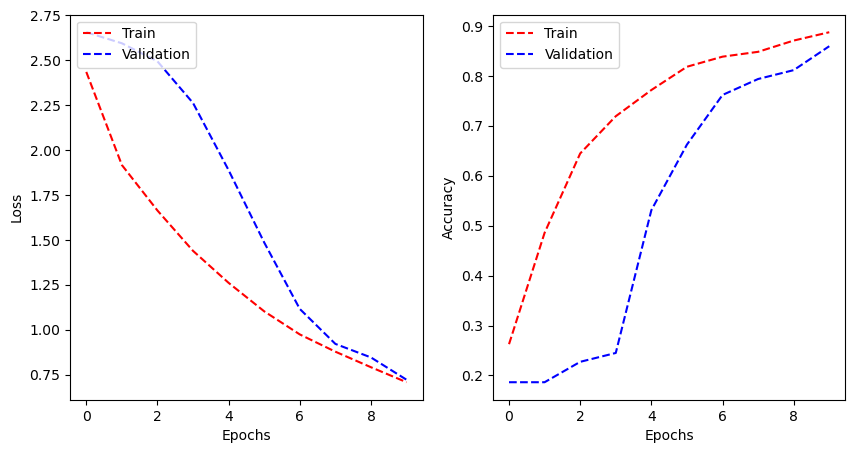

In [54]:
# Plot learning curves using the custom function
plot_learning_curve(history_sign_basic_cnn_normalised.history['loss'], history_sign_basic_cnn_normalised.history['val_loss'],
                    history_sign_basic_cnn_normalised.history['accuracy'], history_sign_basic_cnn_normalised.history['val_accuracy'],
                    metric_name='Accuracy')

In [55]:
# Evaluate the sign model on validation data
print("Performace Metrics of Basic CNN Model with Batch Normalisation for Sign on Validation data:-")
sign_cm_cnn_val = evaluate_model(sign_model_basic_cnn_normalised, X_val_sign_cnn, y_val_sign,"CNN Model 2","Sign","Validation",3);

Performace Metrics of Basic CNN Model with Batch Normalisation for Sign on Validation data:-
Accuracy:  0.8597
Precision:  0.8763
Recall:  0.8597
F1 Score:  0.8507
Cohen's Kappa:  0.8455


Performace Metrics of Basic CNN Model with Batch Normalisation for Sign on Test data:-
Accuracy:  0.8828
Precision:  0.8964
Recall:  0.8828
F1 Score:  0.8788
Cohen's Kappa:  0.8711


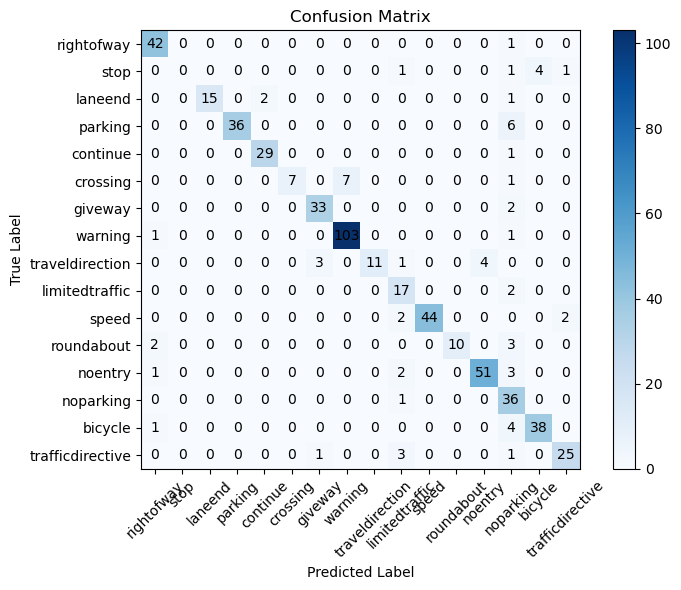

In [56]:
# Evaluate the sign model on test data
print("Performace Metrics of Basic CNN Model with Batch Normalisation for Sign on Test data:-")
sign_cm_cnn_test = evaluate_model(sign_model_basic_cnn_normalised, X_test_sign_cnn, y_test_sign,"CNN Model 2","Sign","Test",3);

# Visualise Confusion matrix
visualise_cm(sign_cm_cnn_test, class_labels_sign)

Batch normalization has been a transformative addition to our basic CNN model, yielding substantial improvements in performance metrics across both validation and test datasets. Below, we detail the observed accuracy improvements:

#### Shape Classification
- **Validation Accuracy**: 0.9892
- **Test Accuracy**: 0.9928

#### Sign Classification
- **Validation Accuracy**: 0.984
- **Test Accuracy**: 0.9805

These metrics demonstrate that batch normalization not only improves the model's training stability but also enhances its generalization capabilities, resulting in high performance on both validation and test datasets.

### Analysis of Batch Normalization Impact

1. **Stabilized Learning Process**:
   - Batch normalization reduces internal covariate shift, ensuring that the distribution of inputs to each layer remains stable throughout training. This stabilization results in a more consistent and reliable learning process, enabling the model to converge more quickly and effectively.
2. **Improved Gradient Flow**:
   - By normalizing the inputs to each layer, batch normalization helps maintain the scale of gradients within a manageable range. This prevents issues like exploding or vanishing gradients, which are common in deep networks, thereby enhancing the gradient flow and facilitating more efficient weight updates.
3. **Higher Learning Rates**:
   - The normalization of inputs allows the use of higher learning rates without risking instability in training. This accelerates the training process, enabling faster convergence to optimal performance.
4. **Regularization Effect**:
   - Batch normalization introduces a slight regularization effect by adding noise to the learning process through batch statistics. This helps prevent overfitting, as the model becomes less sensitive to minor fluctuations in the training data.

## 5.3 CNN Model Optimisation (Model 4)


### Further Enhancements with Regularization, Dropout, and Padding

To further improve the model's robustness and generalization capabilities, we can incorporate additional techniques such as L2 regularization, dropout, and padding. Although these methods might initially result in a slight decrease in accuracy, they offer several long-term benefits:

1. **L2 Regularization**: Applying L2 regularization penalizes large weights, encouraging the model to maintain simpler, more generalizable patterns. This helps in preventing overfitting, where the model performs well on training data but poorly on unseen data.

2. **Dropout**: Introducing dropout randomly deactivates a fraction of neurons during each training iteration. This prevents the model from becoming overly reliant on specific neurons, thereby improving its ability to generalize and reducing the risk of overfitting.

3. **Padding**: Using padding ensures that the spatial dimensions of the input are preserved after convolution operations, allowing the model to learn features more effectively, especially near the edges of the input images.

While these techniques might reduce the immediate accuracy slightly, they contribute to a more robust and generalizable model, which is crucial for maintaining high performance on new, unseen data. Incorporating these methods will ultimately lead to a more reliable and versatile CNN model.

### Function Parameters:
- `num_classes`: Number of output classes for the classification task.
- `activation`: Activation function to use in the layers (default is 'sigmoid').
- `optimizer`: Optimizer to use for model compilation (default is 'SGD'). Options include 'SGD', 'Adam', and 'RMSprop'.
- `dropout_rate`: Dropout rate for regularization (default is 0.0).
- `num_layers`: Number of convolutional layers (default is 3).
- `layer_size`: Number of filters in each convolutional layer (default is 128).
- `use_bias`: Whether to use bias in the layers (default is True).
- `learning rate`: Optional learning rate for the optimizer.

### Model Architecture:
1. **Input Layer**: Accepts 28x28 grayscale images.
2. **Convolutional Layers**: Configurable number of layers with specified filter sizes and activation functions.
3. **Pooling Layers**: Max pooling layers after each convolutional layer.
4. **Flatten Layer**: Converts 2D feature maps to a 1D feature vector.
5. **Dropout Layer**: Adds dropout for regularization.
6. **Fully Connected Layers**: Includes a dense layer followed by the output layer with a softmax activation function.

### Model Compilation:
- The model is compiled using the specified optimizer and categorical cross-entropy loss function.
- Metrics tracked during training include accuracy.

**Note : This function is designed to be compatible with later parameter tuning, allowing easy customization of activation functions and optimizers to suit specific classification tasks.**

In [57]:
# Function to create basic CNN model 
def create_cnn_model(num_classes, activation='relu', optimizer='adam', dropout_rate=0.6, num_layers=3, layer_size=64, use_bias=True,learning_rate=0.01):
    model = Sequential([
                    Input(shape=(28, 28, 1)),
                    Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01), activation=None, padding='same'),
                    BatchNormalization(),  
                    Activation(activation),
                    MaxPooling2D(pool_size=(2, 2)),
                    Dropout(dropout_rate)
                    ])
    
    for _ in range(num_layers - 1):
        model.add(Conv2D(layer_size, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01), activation=None, use_bias=use_bias, padding='same'))
        model.add(BatchNormalization())
        Activation(activation),
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_rate))
        
    model.add(Flatten())
    # Add dropout
    model.add(Dropout(dropout_rate))
    
    # Add fully connected layers
    model.add(Dense(128, activation=activation, use_bias=use_bias))
    model.add(Dense(num_classes, activation='softmax', use_bias=use_bias))  
        
    # Compile the model
    if optimizer == 'SGD':
        optimizer = SGD(learning_rate=learning_rate) 
    elif optimizer == 'Adam':
        optimizer = Adam(learning_rate=learning_rate) 
    elif optimizer == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate) 
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### 5.3.1 CNN Model Creation and Training for Shape Classification

#### Model Creation
The `create_cnn_model` function is used to create a Convolutional Neural Network (CNN) model specifically designed for shape classification. The model is configured with the specified number of output classes (`num_classes_shape`).

#### Model Training
The CNN model (`shape_model_cnn`) is trained using the training data (`X_train_shape_cnn` and `y_train_shape_one_hot`) for `10` epochs with a batch size of `30`. Training progress is monitored on the validation data (`X_val_shape_cnn` and `y_val_shape`), and the training process is executed without verbosity (`verbose=0`).

A summary of the created CNN model is printed using the `model_summary` function. This provides insights into the architecture of the model, including the number of layers, parameters, and output shapes.

This process facilitates the creation, inspection, and training of a CNN model tailored specifically for shape classification.

In [58]:
# Create CNN model
shape_model_cnn = create_cnn_model(num_classes_shape)

#Print model summary
model_summary(shape_model_cnn)

# Train the model 
history_shape_model_cnn = shape_model_cnn.fit(X_train_shape_cnn,
                    y_train_shape,
                    epochs=10, batch_size=30, 
                    verbose=0, 
                    validation_data=(X_val_shape_cnn, y_val_shape))

Model Summary:



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,885 (511.27 KB)

 Trainable params: 130,565 (510.02 KB)

 Non-trainable params: 320 (1.25 KB)

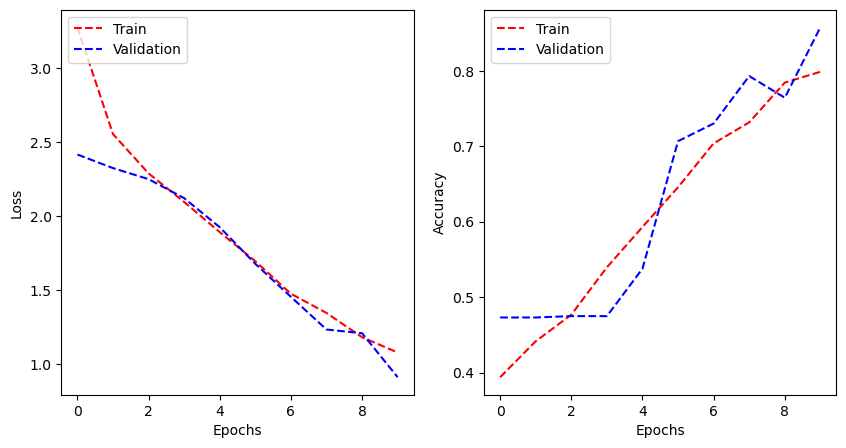

In [59]:
# Plot learning curves using the custom function
plot_learning_curve(history_shape_model_cnn.history['loss'], history_shape_model_cnn.history['val_loss'],
                    history_shape_model_cnn.history['accuracy'], history_shape_model_cnn.history['val_accuracy'],
                    metric_name='Accuracy')

In [60]:
# Evaluate the shape model on validation data
print("Performace Metrics of Basic CNN Model with Optimisation for Shape on Validation data:-")
shape_cm_cnn_val = evaluate_model(shape_model_cnn, X_val_shape_cnn, y_val_shape,"CNN Model 3","Shape","Validation",4);

Performace Metrics of Basic CNN Model with Optimisation for Shape on Validation data:-
Accuracy:  0.8579
Precision:  0.8758
Recall:  0.8579
F1 Score:  0.862
Cohen's Kappa:  0.79


Performace Metrics of Basic CNN Model with Optimisation for Shape on Test data:-
Accuracy:  0.8671
Precision:  0.8685
Recall:  0.8671
F1 Score:  0.8628
Cohen's Kappa:  0.8011


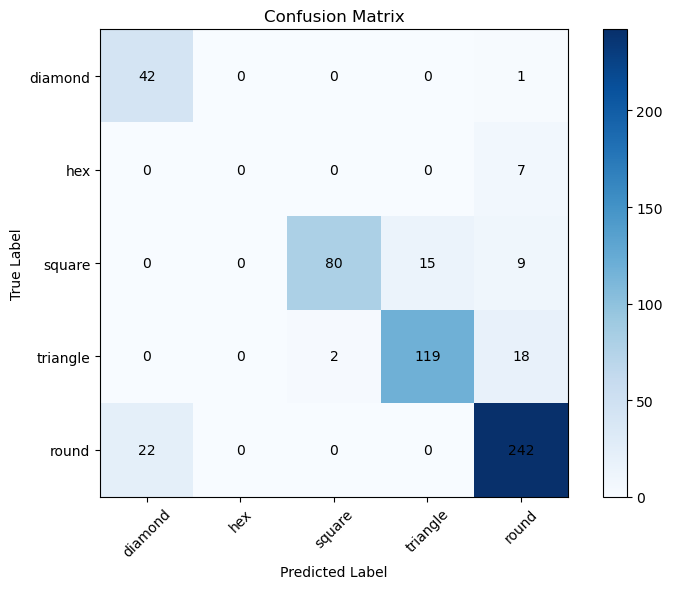

In [61]:
# Evaluate the shape model on test data
print("Performace Metrics of Basic CNN Model with Optimisation for Shape on Test data:-")
shape_cm_cnn_test = evaluate_model(shape_model_cnn, X_test_shape_cnn, y_test_shape,"CNN Model 3","Shape","Test",4);

# Visualise Confusion matrix
visualise_cm(shape_cm_cnn_test, class_labels_shape)

### 5.3.2 CNN Model Creation and Training for Sign Classification

#### Model Creation
The `create_cnn_model` function is used to create a Convolutional Neural Network (CNN) model specifically designed for sign classification. The model is configured with the specified number of output classes (`num_classes_sign`).


#### Model Training
The CNN model (`sign_model_cnn`) is trained using the training data (`X_train_sign_cnn` and `y_train_sign`) for `10` epochs with a batch size of `30`. Training progress is monitored on the validation data (`X_val_sign_cnn` and `y_val_sign`), and the training process is executed without verbosity (`verbose=0`).

This process facilitates the creation, inspection, and training of a CNN model tailored specifically for sign classification.

In [62]:
# Create CNN model
sign_model_cnn = create_cnn_model(num_classes_sign)

#Print model summary
model_summary(sign_model_cnn)

# Train the model 
history_sign_model_cnn =sign_model_cnn.fit(X_train_sign_cnn, 
                   y_train_sign, 
                   epochs=10, 
                   batch_size=30, 
                   verbose=0,
                   validation_data=(X_val_sign_cnn, y_val_sign))

Model Summary:



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,304 (516.81 KB)

 Trainable params: 131,984 (515.56 KB)

 Non-trainable params: 320 (1.25 KB)

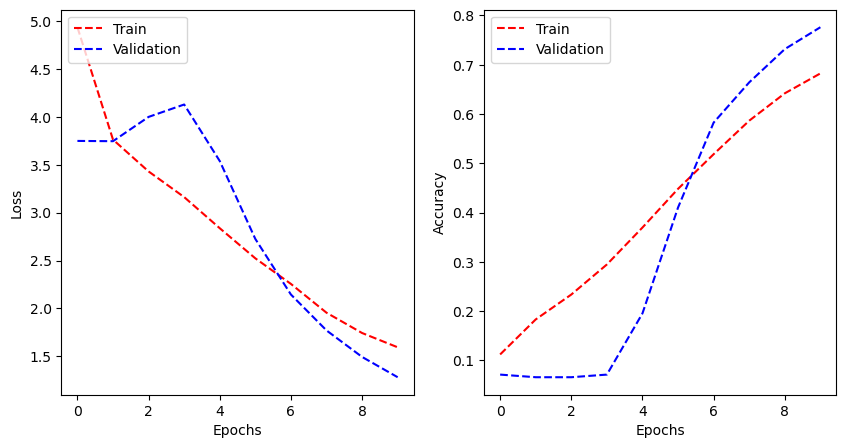

In [63]:
# Plot learning curves using the custom function
plot_learning_curve(history_sign_model_cnn.history['loss'], history_sign_model_cnn.history['val_loss'],
                    history_sign_model_cnn.history['accuracy'], history_sign_model_cnn.history['val_accuracy'],
                    metric_name='Accuracy')

In [64]:
# Evaluate the sign model on validation data
print("Performace Metrics of Basic CNN Model with Optimisation for Sign on Validation data:-")
sign_cm_cnn_val = evaluate_model(sign_model_cnn, X_val_sign_cnn, y_val_sign,"CNN Model 3","Sign","Validation",4);

Performace Metrics of Basic CNN Model with Optimisation for Sign on Validation data:-
Accuracy:  0.7762
Precision:  0.8205
Recall:  0.7762
F1 Score:  0.7713
Cohen's Kappa:  0.7542


Performace Metrics of Basic CNN Model with Optimisation for Sign on Test data:-
Accuracy:  0.7798
Precision:  0.8383
Recall:  0.7798
F1 Score:  0.7814
Cohen's Kappa:  0.7588


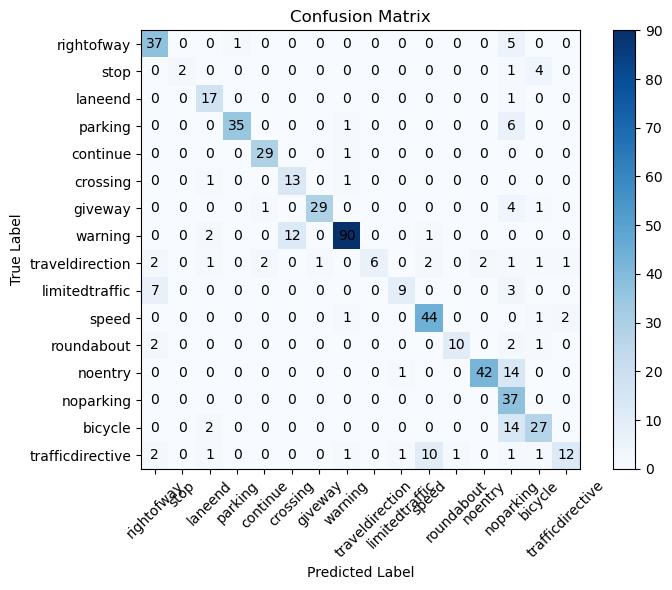

In [65]:
# Evaluate the sign model on test data
print("Performace Metrics of Basic CNN Model with Optimisation for Sign on Test data:-")
sign_cm_cnn_test = evaluate_model(sign_model_cnn, X_test_sign_cnn, y_test_sign,"CNN Model 3","Sign","Test",4);

# Visualise Confusion matrix
visualise_cm(sign_cm_cnn_test, class_labels_sign)

## 6. Data Augmentation for Shape and Sign Training Data

### Data Augmentation Process

The following code snippet performs data augmentation on the training data for both shapes and signs using the `augment_data` function and `ImageDataGenerator` from Keras. This process helps to artificially increase the size and diversity of the training dataset, improving the model's ability to generalize.

- The `augment_data` function takes the original training data and an `ImageDataGenerator` instance to generate additional augmented images for each class label. It ensures that each original image generates a specified number of augmented images (`augmentation_limit`).

- An `ImageDataGenerator` is initialized with various augmentation parameters, such as rotation, width shift, height shift, horizontal and vertical flips, zoom, and rescaling. These transformations enhance the diversity of the training data by creating variations of the original images.

- The augmentation process is applied separately to the shape and sign training datasets. For each class label, new augmented images are created and combined with the original images to form a larger and more diverse training set.

- The total number of augmented images generated for both shape and sign data is calculated, indicating the effectiveness of the augmentation process in increasing the dataset size.

Data augmentation is crucial in machine learning to improve model performance by providing a more extensive and varied dataset. This process helps the model generalize better and reduces the risk of overfitting.

In [66]:
# Function to perform data augmentation
def augment_data(data, datagen, augmentation_limit):
    combined_data = {}
    total_augmented_images = 0
    first_augmented_images = []

    for label, images in data.items():
        augmented_images = []
        for img in images:
            augmented_images_ind = []
            img = np.expand_dims(img, axis=0)   # Add batch size dimension
            num_augmented_images = 0
            for augmented_img in datagen.flow(img, batch_size=1):
                augmented_img = augmented_img[0]
                augmented_images.append(augmented_img)
                augmented_images_ind.append(augmented_img)
                num_augmented_images += 1
                if num_augmented_images >= augmentation_limit:
                    break
            if label in combined_data:
                combined_data[label].append(img)
                combined_data[label].extend(augmented_images_ind)
            else:
                combined_data[label] = [img] + augmented_images_ind
            if not first_augmented_images:
                first_augmented_images = [img] + augmented_images
        total_augmented_images += len(augmented_images)

    return combined_data, first_augmented_images

# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest',
    rescale=1.0/255,
    data_format='channels_last'
)

#Number of Augmented Images Generated
num_aug_img = 2

# Apply augmentation to the entire training data for shapes
combined_shape_data, first_augmented_shape_images = augment_data(train_shape_data, datagen, num_aug_img)

# Apply augmentation to the entire training data for signs
combined_sign_data, _ = augment_data(train_sign_data, datagen, num_aug_img)

# Count total augmented images
total_augmented_shape_images = sum(len(images) for images in combined_shape_data.values())
total_augmented_sign_images = sum(len(images) for images in combined_sign_data.values())


### 6.1 Visualization of Augmented Shape Images

This code snippet visualizes the original and augmented shape images to provide a visual understanding of how data augmentation modifies the images. The first image shown is the original, followed by several augmented versions created through the augmentation process. This helps in validating the effectiveness of the data augmentation in creating diverse training samples.

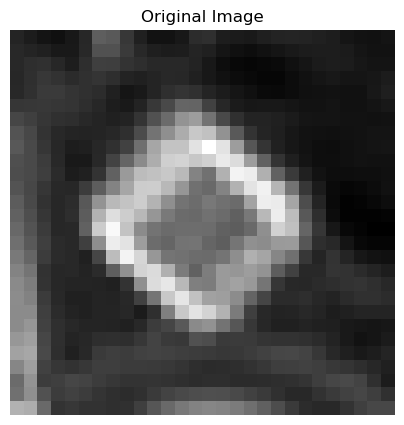

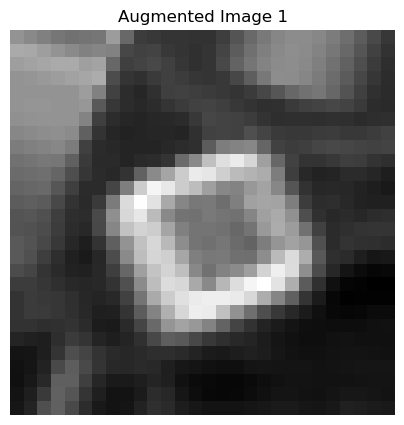

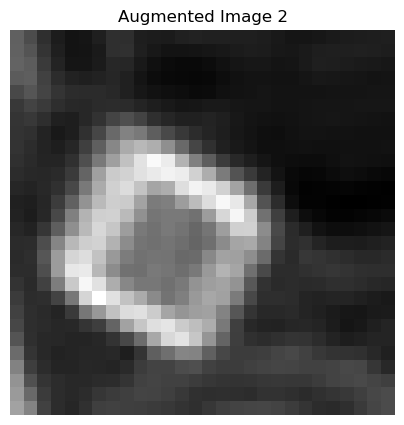

In [67]:
# Display first sample of augmented shape images
first_augmented_shape_images = [img for img in first_augmented_shape_images if isinstance(img, np.ndarray)]

# Define the number of images to visualize
num_images_to_visualize = len(first_augmented_shape_images)

# Visualize the images
for i in range(num_images_to_visualize):
    plt.figure(figsize=(5, 5))
    plt.imshow(first_augmented_shape_images[i].squeeze(), cmap='gray')
    if i == 0:
        plt.title(f"Original Image")
    elif i != 0:
        plt.title(f"Augmented Image {i}")
    plt.axis('off')
    plt.show()


### 6.2 Combined Dataset for Shapes (Original and Augmented)
This code snippet creates a combined table that displays the count of original and augmented images for each shape type. It also includes a total count for all shape types, providing a clear view of how augmentation has increased the dataset size. This table helps in understanding the distribution of original and augmented data within the dataset.

In [68]:
# Combined table for original and augmented data for shapes
combined_shape_table = []
total_original_shapes = 0
total_augmented_shapes = 0

for shape_label, images in combined_shape_data.items():
    original_count = len(train_shape_data[shape_label])
    augmented_count = len(images) - original_count
    total_original_shapes += original_count
    total_augmented_shapes += augmented_count
    combined_shape_table.append([shape_label, original_count, augmented_count, original_count + augmented_count])

# Add a row for the total count
combined_shape_table.append(["Total", total_original_shapes, total_augmented_shapes, total_original_shapes + total_augmented_shapes])

# Print the combined table
print("Combined Dataset for Shapes (Original and Augmented):")
print(tabulate(combined_shape_table, headers=["Shape Type", "Original", "Augmented", "Combined"]))


Combined Dataset for Shapes (Original and Augmented):
Shape Type      Original    Augmented    Combined
------------  ----------  -----------  ----------
diamond              196          392         588
hex                   29           58          87
square               480          960        1440
triangle             648         1296        1944
round               1227         2454        3681
Total               2580         5160        7740


### 6.3 Combined Dataset for Signs (Original and Augmented)

This code snippet generates a combined table presenting the counts of original and augmented images for each sign type. It also includes a total count for all sign types, giving an overview of the dataset's composition post-augmentation. The table facilitates understanding the distribution of original and augmented data within the sign dataset.

In [69]:
# Combined table for original and augmented data for signs
combined_sign_table = []
total_original_signs = 0
total_augmented_signs = 0

for sign_label, images in combined_sign_data.items():
    original_count = len(train_sign_data[sign_label])
    augmented_count = len(images) - original_count
    total_original_signs += original_count
    total_augmented_signs += augmented_count
    combined_sign_table.append([sign_label, original_count, augmented_count, original_count + augmented_count])

# Add a row for the total count
combined_sign_table.append(["Total", total_original_signs, total_augmented_signs, total_original_signs + total_augmented_signs])

# Print the combined table
print("Combined Dataset for Signs (Original and Augmented):")
print(tabulate(combined_sign_table, headers=["Sign Type", "Original", "Augmented", "Combined"]))


Combined Dataset for Signs (Original and Augmented):
Sign Type           Original    Augmented    Combined
----------------  ----------  -----------  ----------
rightofway               196          392         588
stop                      29           58          87
laneend                   82          164         246
parking                  192          384         576
continue                 139          278         417
crossing                  65          130         195
giveway                  161          322         483
warning                  485          970        1455
traveldirection           86          172         258
limitedtraffic            87          174         261
speed                    220          440         660
roundabout                68          136         204
noentry                  261          522         783
noparking                168          336         504
bicycle                  199          398         597
trafficdirective         135 

### 6.4 Resizing Images to 28x28

The provided code snippet defines a function resize_images to resize images to a dimension of 28x28. It then applies this function to both the combined_shape_data and combined_sign_data, resulting in resized versions of the images. This resizing process ensures consistency in image dimensions, making them suitable for further processing, such as training machine learning models.

In [70]:
# Resize images to 28x28
def resize_images(images):
    resized_images = [np.reshape(img, (28, 28, 1)) for img in images]
    return resized_images

# Resize images in combined_shape_data and combined_sign_data
combined_shape_data_resized = {label: resize_images(images) for label, images in combined_shape_data.items()}
combined_sign_data_resized = {label: resize_images(images) for label, images in combined_sign_data.items()}

### 6.5 Preparing Training Data for Shape and Sign

The provided code snippet prepares training data for both shape and sign datasets after augmentation. It concatenates the resized images and generates corresponding labels for training. For the shape dataset, it creates one-hot encoded labels, while for the sign dataset, it directly assigns numerical labels. These processed datasets are then ready for training machine learning models.

In [71]:
# Prepare training data for Shape
X_aug_shape_cnn = np.concatenate([np.array(images) for images in combined_shape_data_resized.values()])

y_aug_shape_cnn = np.concatenate([np.full(len(images), label_to_index_shape[label]) for label, images in combined_shape_data_resized.items()])
y_aug_shape = np.eye(num_classes_shape)[y_aug_shape_cnn]

# Prepare training data for Sign
X_aug_sign_cnn = np.concatenate([np.array(images) for images in combined_sign_data_resized.values()])

y_aug_sign_cnn = np.concatenate([np.full(len(images), label_to_index_sign[label]) for label, images in combined_sign_data_resized.items()])
y_aug_sign = np.eye(num_classes_sign)[y_aug_sign_cnn]

## 6.6 CNN Model with Augmented Data (Model 5)

### 6.6.1 Creating and Training Optimized CNN Model for Shape after Train Data Augmentation 

In this code snippet, an optimized CNN model for the shape dataset is created and trained after augmenting the training data. The function `create_optimised_cnn_model` is used to perform hyperparameter tuning via grid search. The best parameters obtained from the grid search are then used to create the CNN model (`shape_model_cnn_aug`). The model is trained using the augmented training data (`X_aug_shape_cnn` and `y_aug_shape`) and validated using the validation data (`X_val_shape_cnn` and `y_val_shape`). Finally, a summary of the model along with the best parameters is printed.

In [72]:
# Create CNN model
shape_model_cnn_aug = create_cnn_model(num_classes_shape)

#Print model summary
model_summary(shape_model_cnn_aug)

# Train the model 
history_shape_model_cnn_aug = shape_model_cnn_aug.fit(X_aug_shape_cnn,
                    y_aug_shape,
                    epochs=10, batch_size=30, 
                    verbose=0, 
                    validation_data=(X_val_shape_cnn, y_val_shape))

Model Summary:



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,885 (511.27 KB)

 Trainable params: 130,565 (510.02 KB)

 Non-trainable params: 320 (1.25 KB)

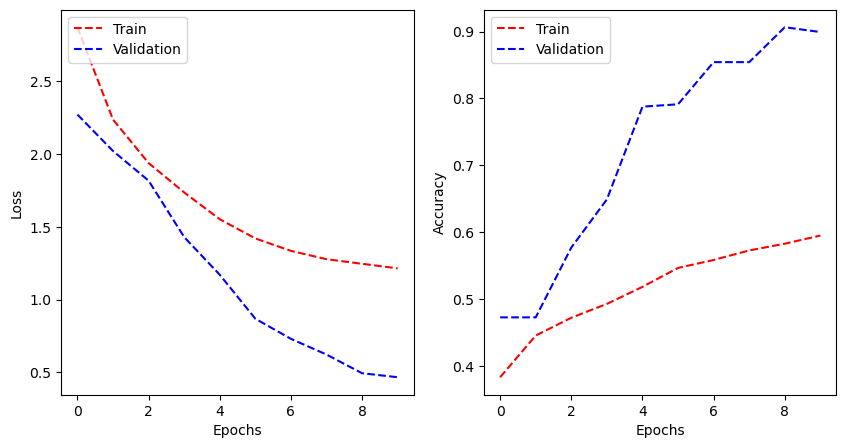

In [73]:
# Plot learning curves using the custom function
plot_learning_curve(history_shape_model_cnn_aug.history['loss'], history_shape_model_cnn_aug.history['val_loss'],
                    history_shape_model_cnn_aug.history['accuracy'], history_shape_model_cnn_aug.history['val_accuracy'],
                    metric_name='Accuracy')

#### Evaluation and Visualization of the Optimized CNN Model for Shape Classification on Validation Data after Augmentation

This code evaluates the performance metrics of an optimized CNN model for shape recognition on validation data after augmenting the training data and visualizes the confusion matrix to assess classification performance.

In [74]:
# Evaluate the model on validation data
print("Performace Metrics of Optimised CNN Model for Shape on Validation data after augmentation of training data:-")
shape_cm_cnn_aug_val = evaluate_model(shape_model_cnn_aug, X_val_shape_cnn, y_val_shape,"CNN Model 4","Shape","Validation",5);

Performace Metrics of Optimised CNN Model for Shape on Validation data after augmentation of training data:-
Accuracy:  0.8993
Precision:  0.904
Recall:  0.8993
F1 Score:  0.8976
Cohen's Kappa:  0.8462


#### Evaluation and Visualization of the Optimized CNN Model for Shape Classification on Test Data after Augmentation
This code evaluates the performance metrics of an optimized CNN model for shape recognition on test data after augmenting the training data and visualizes the confusion matrix to assess classification performance.

Performace Metrics of Optimised CNN Model for Shape on Test data after augmentation of training data:-
Accuracy:  0.9102
Precision:  0.9029
Recall:  0.9102
F1 Score:  0.9039
Cohen's Kappa:  0.8633


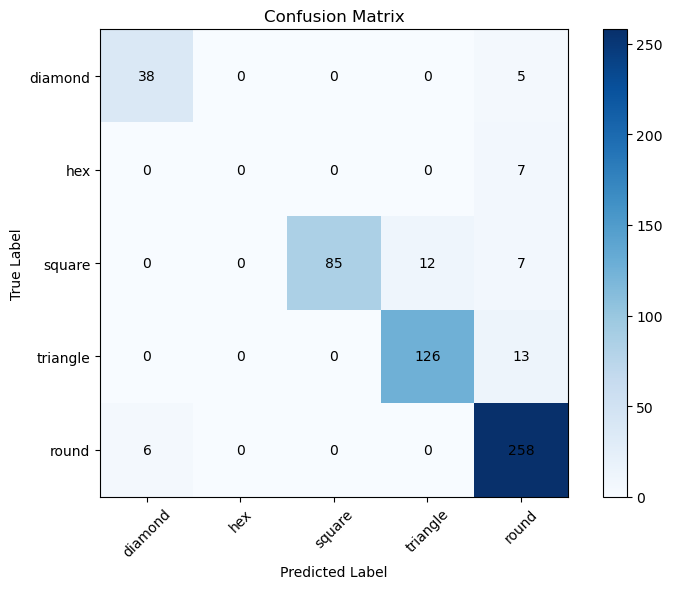

In [75]:
# Evaluate the model on test data
print("Performace Metrics of Optimised CNN Model for Shape on Test data after augmentation of training data:-")
shape_cm_cnn_aug_test = evaluate_model(shape_model_cnn_aug, X_test_shape_cnn, y_test_shape,"CNN Model 4","Shape","Test",5);

# Visualise Confusion matrix
visualise_cm(shape_cm_cnn_aug_test, class_labels_shape)

### 6.6.2 Creating and Training Optimized CNN Model for Sign after Train Data Augmentation

Creating an optimized CNN model for sign recognition, this code employs data augmentation on the training set and utilizes grid search for hyperparameter optimization. After training the model using the augmented training data and validating it on the validation set, a summary of the model, along with the best parameters, is printed.

In [76]:
# Create CNN model
sign_model_cnn_aug = create_cnn_model(num_classes_sign)

#Print model summary
model_summary(sign_model_cnn_aug)

# Train the model 
history_sign_model_cnn_aug = sign_model_cnn_aug.fit(X_aug_sign_cnn,
                    y_aug_sign,
                    epochs=10, batch_size=30, 
                    verbose=0, 
                    validation_data=(X_val_sign_cnn, y_val_sign))

Model Summary:



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,304 (516.81 KB)

 Trainable params: 131,984 (515.56 KB)

 Non-trainable params: 320 (1.25 KB)

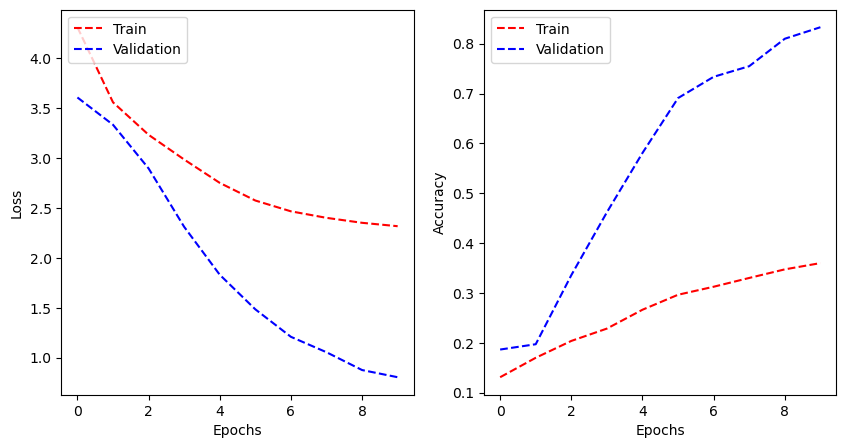

In [77]:
# Plot learning curves using the custom function
plot_learning_curve(history_sign_model_cnn_aug.history['loss'], history_sign_model_cnn_aug.history['val_loss'],
                    history_sign_model_cnn_aug.history['accuracy'], history_sign_model_cnn_aug.history['val_accuracy'],
                    metric_name='Accuracy')

#### Evaluation and Visualization of the Optimized CNN Model for Sign Classification on Validation Data after Augmentation

This code evaluates the performance metrics of an optimized CNN model for sign recognition on validation data after augmenting the training data. It also visualizes the confusion matrix to assess classification performance.

In [78]:
# Evaluate the model on validation data
print("Performace Metrics of Optimised CNN Model for Sign on Validation data after augmentation of training data:-")
sign_cm_cnn_aug_val = evaluate_model(sign_model_cnn_aug, X_val_sign_cnn, y_val_sign,"CNN Model 4","Sign","Validation",5);

Performace Metrics of Optimised CNN Model for Sign on Validation data after augmentation of training data:-
Accuracy:  0.833
Precision:  0.85
Recall:  0.833
F1 Score:  0.8276
Cohen's Kappa:  0.8169


#### Evaluation and Visualization of the Optimized CNN Model for Sign Classification on Test Data after Augmentation
This code evaluates the performance metrics of an optimized CNN model for sign recognition on test data after augmenting the training data. It then visualizes the confusion matrix to assess classification performance.

Performace Metrics of Optimised CNN Model for Sign on Test data after augmentation of training data:-
Accuracy:  0.8508
Precision:  0.8731
Recall:  0.8508
F1 Score:  0.8447
Cohen's Kappa:  0.8362


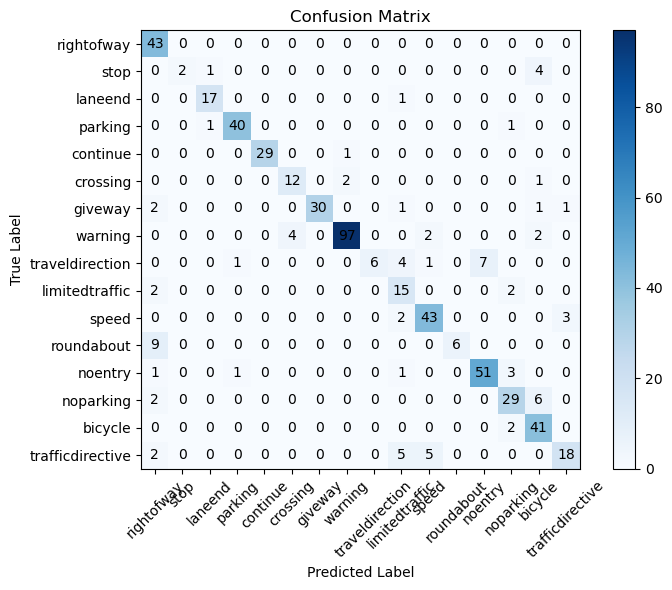

In [79]:
# Evaluate the model on test data
print("Performace Metrics of Optimised CNN Model for Sign on Test data after augmentation of training data:-")
sign_cm_cnn_aug_test = evaluate_model(sign_model_cnn_aug, X_test_sign_cnn, y_test_sign,"CNN Model 4","Sign","Test",5);

# Visualise Confusion matrix
visualise_cm(sign_cm_cnn_aug_test, class_labels_sign)

## 7. Edge Detection Preprocessing for CNN Models: Enhancing Shape and Sign Recognition

This code snippet introduces edge detection preprocessing for CNN models, particularly beneficial for shape and sign recognition tasks. By applying the Canny edge detection algorithm to images, the resulting edge-detected images enhance features relevant to shape and sign identification. These preprocessed images are then utilized for training, validation, and testing CNN models.

### Benefits for Shape and Sign Recognition

- Edge detection highlights key features such as edges, corners, and contours, which are crucial for identifying shapes and signs. This enhanced feature representation improves the model's ability to distinguish between different shapes and signs.

- Edge-detected images are less sensitive to variations in lighting conditions, backgrounds, and image distortions. This robustness ensures that the CNN models can effectively recognize shapes and signs across diverse real-world scenarios.

- Edge detection simplifies the input images by reducing them to their essential features, making it easier for the CNN models to learn and generalize patterns associated with different shapes and signs.

- The preprocessed edge-detected images provide a more compact representation of the original images, reducing computational complexity and memory requirements during model training and inference.


In [80]:
# Function to perform Canny edge detection on a single image
def detect_edges(image):
    # Convert image to uint8
    image_uint8 = (image * 255).astype(np.uint8)
    # Perform Canny edge detection
    edges = cv2.Canny(image_uint8, 100, 200)  # You can adjust the threshold values
    return edges

# Function to preprocess images
def preprocess_images(data_dict):
    augmented_edges = []
    for images in data_dict.values():
        for image in images:
            edges = detect_edges(image)
            augmented_edges.append(edges)
    augmented_edges = np.array(augmented_edges)
    augmented_edges = np.expand_dims(augmented_edges, axis=-1)  # Add channel dimension
    return augmented_edges

# Preprocess training data
X_aug_shape_cnn_edge = preprocess_images(combined_shape_data_resized)
X_aug_sign_cnn_edge = preprocess_images(combined_sign_data_resized)

# Preprocess validation data
X_val_shape_cnn_edge = preprocess_images(val_shape_data)
X_val_sign_cnn_edge = preprocess_images(val_sign_data)

# Preprocess test data
X_test_shape_cnn_edge = preprocess_images(test_shape_data)
X_test_sign_cnn_edge = preprocess_images(test_sign_data)


# 8. Optimizing CNN Model Parameters with Grid Search (Model 6)
This function optimizes a Convolutional Neural Network (CNN) model by performing grid search over various hyperparameters such as activation functions, optimizers, number of layers, and layer sizes. It leverages GridSearchCV to find the best combination of parameters for the given training data. Additionally, it utilizes EarlyStopping and ReduceLROnPlateau callbacks for better convergence and performance.

1. **Parameter Grid Definition**: 
    - The `param_grid` dictionary specifies the hyperparameters to be tuned, including activation function, optimizer, dropout rate, number of layers, layer size, bias usage, and learning rate.

2. **CNN Model Wrapper**:
    - The `KerasClassifier` wrapper is used to integrate the CNN model with scikit-learn’s `GridSearchCV` for hyperparameter tuning.

3. **Grid Search Setup**:
    - The `GridSearchCV` object is created with the `KerasClassifier` estimator and the defined parameter grid. It performs a cross-validated grid search to find the best combination of hyperparameters.

4. **Model Fitting**:
    - The grid search is executed by fitting it to the training data (`X_train`, `y_train`) with validation data (`X_val`, `y_val`). The grid search will train multiple models with different hyperparameter combinations and evaluate their performance.

5. **Best Parameters Extraction**:
    - The best set of hyperparameters is extracted from the grid search results. The prefix 'model__' is removed from the parameter keys.

6. **Final Model Training**:
    - A new CNN model is created with the optimized hyperparameters and trained on the training data. This final model is then returned along with the best hyperparameters.

This function automates the process of finding the optimal hyperparameters for a CNN model, ensuring that the final model is well-tuned for the classification task. The use of grid search allows for systematic and thorough exploration of different hyperparameter combinations, ultimately leading to improved model performance.

In [81]:
# Function to optimise CNN model
def create_optimised_cnn_model(num_classes, X_train, y_train, X_val, y_val):

    # Parametes for tuning
    param_grid = {
    'model__activation': ['sigmoid','relu'], 
    'model__optimizer': ['SGD','adam'],
    'model__num_layers': [3,4],
    'model__layer_size': [64,128]
    }
    
    # Create CNN KerasClassifier
    model = KerasClassifier(model = create_cnn_model, num_classes=num_classes, verbose=0)
    
    # Perform Grid Search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    
    # Fit the GridSearchCV
    grid_result = grid_search.fit(X_train, y_train, epochs=10, batch_size=50, verbose=0, validation_data=(X_val, y_val)) 
    
    best_params = grid_result.best_params_
    
    # Remove 'model__' from all keys
    best_params = {key.replace('model__', ''): value for key, value in best_params.items()} 
    
    # Configure EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

    cnn_model = create_cnn_model(num_classes, **best_params)
    history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    return cnn_model, best_params, history

## 8.1 Creating and Training Optimized CNN Model for Shape Recognition after Feature Extraction

In [82]:
# Create and Train the Optimised CNN model for Shape after Feature Extraction
shape_model_cnn_edge, best_params_shape_edge, history_shape_model_cnn_edge = create_optimised_cnn_model(num_classes_shape, 
                                                                          X_aug_shape_cnn_edge, 
                                                                          y_aug_shape,
                                                                          X_val_shape_cnn_edge, 
                                                                          y_val_shape)
 
#Print model summary
model_summary(shape_model_cnn_edge, best_params_shape_edge)

Model Summary:



Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,001,681 (3.82 MB)

 Trainable params: 333,701 (1.27 MB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 667,404 (2.55 MB)


Best Values for Model Parameters:-
activation : relu
layer_size : 128
num_layers : 3
optimizer : adam


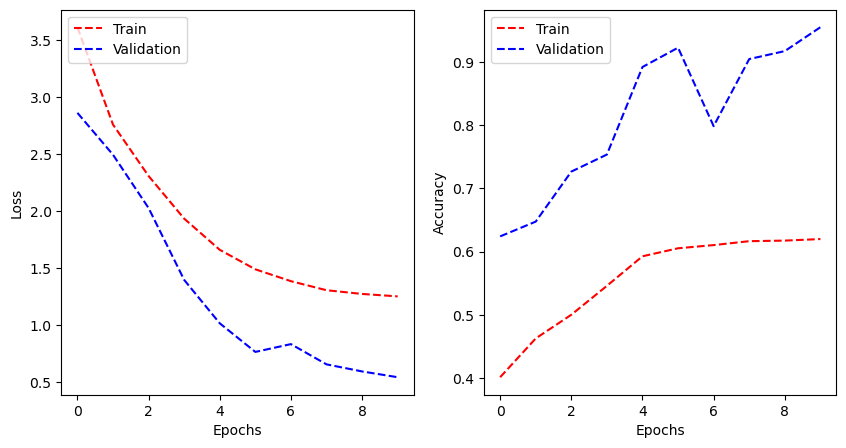

In [83]:
# Plot learning curves using the custom function
plot_learning_curve(history_shape_model_cnn_edge.history['loss'], history_shape_model_cnn_edge.history['val_loss'],
                    history_shape_model_cnn_edge.history['accuracy'], history_shape_model_cnn_edge.history['val_accuracy'],
                    metric_name='Accuracy')

#### Evaluating Optimized CNN Model for Shape Recognition on Validation Data after Feature Extraction

In [84]:
# Evaluate the model on validation data
print("Performace Metrics of Optimised CNN Model for Shape on Validation data after Feature Extraction:-")
shape_cm_cnn_edge_test = evaluate_model(shape_model_cnn_edge, X_val_shape_cnn_edge, y_val_shape,"CNN Model 5","Shape","Validation",6);

Performace Metrics of Optimised CNN Model for Shape on Validation data after Feature Extraction:-
Accuracy:  0.955
Precision:  0.9448
Recall:  0.955
F1 Score:  0.9489
Cohen's Kappa:  0.9321


#### Evaluating Optimized CNN Model for Shape Recognition on Test Data after Feature Extraction

Performace Metrics of Optimsed CNN Model for Shape on Test data after Feature Extraction:-
Accuracy:  0.9641
Precision:  0.9529
Recall:  0.9641
F1 Score:  0.958
Cohen's Kappa:  0.9458


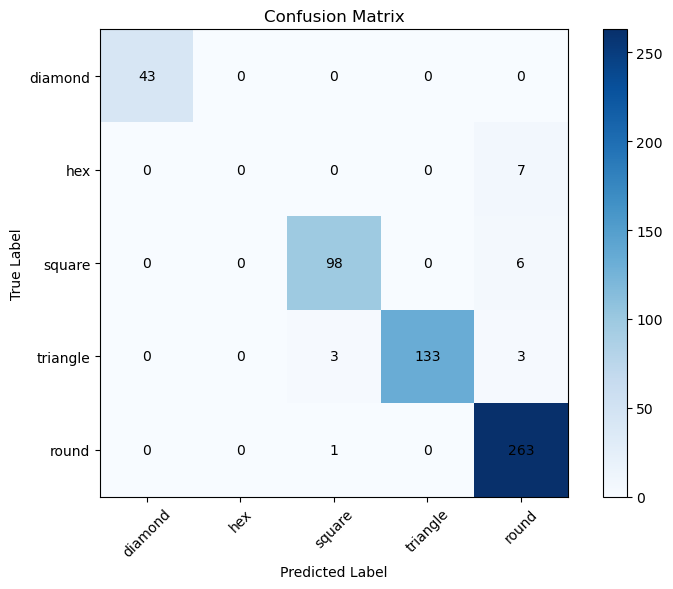

In [85]:
# Evaluate the model on test data
print("Performace Metrics of Optimsed CNN Model for Shape on Test data after Feature Extraction:-")
shape_cm_cnn_edge_val = evaluate_model(shape_model_cnn_edge, X_test_shape_cnn_edge, y_test_shape,"CNN Model 5","Shape","Test",6);

# Visualise Confusion matrix
visualise_cm(shape_cm_cnn_edge_val, class_labels_shape)

## 8.2 Creating and Training Optimized CNN Model for Sign Recognition after Feature Extraction

In [86]:
# Create and Train the Optimised CNN model for Sign after Feature Extraction
sign_model_cnn_edge, best_params_sign_edge, history_sign_model_cnn_edge = create_optimised_cnn_model(num_classes_sign, 
                                                                        X_aug_sign_cnn_edge, 
                                                                        y_aug_sign,
                                                                        X_val_sign_cnn_edge, 
                                                                        y_val_sign)

#Print model summary
model_summary(sign_model_cnn_edge, best_params_sign_edge)

Model Summary:



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 14, 14, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,005,938 (3.84 MB)

 Trainable params: 335,120 (1.28 MB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 670,242 (2.56 MB)


Best Values for Model Parameters:-
activation : relu
layer_size : 128
num_layers : 3
optimizer : adam


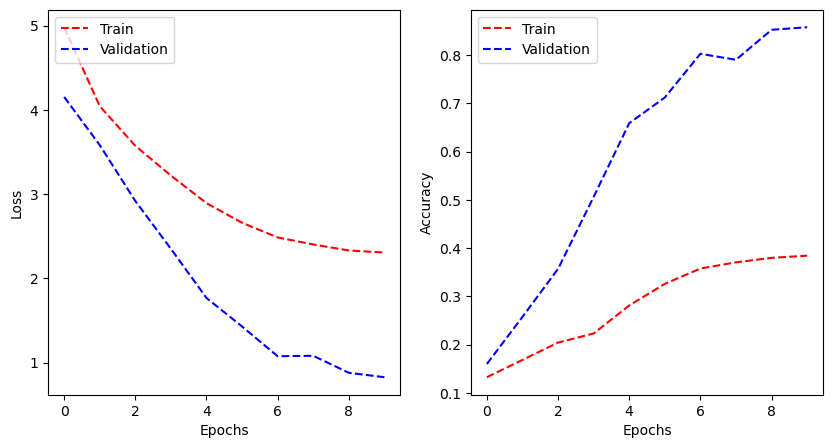

In [87]:
# Plot learning curves using the custom function
plot_learning_curve(history_sign_model_cnn_edge.history['loss'], history_sign_model_cnn_edge.history['val_loss'],
                    history_sign_model_cnn_edge.history['accuracy'], history_sign_model_cnn_edge.history['val_accuracy'],
                    metric_name='Accuracy')

#### Evaluating Optimized CNN Model for Sign Recognition on Validation Data after Feature Extraction

In [88]:
# Evaluate the shape model on validation data
print("Performace Mrtrics of Optimised CNN Model for Sign on Validation data after Feature Extraction:-")
sign_cm_cnn_edge_val = evaluate_model(sign_model_cnn_edge, X_val_sign_cnn_edge, y_val_sign,"CNN Model 5","Sign","Validation",6);

Performace Mrtrics of Optimised CNN Model for Sign on Validation data after Feature Extraction:-
Accuracy:  0.8579
Precision:  0.8572
Recall:  0.8579
F1 Score:  0.8493
Cohen's Kappa:  0.8434


#### Evaluating Optimized CNN Model for Sign Recognition on Test Data after Feature Extraction

Performace Metrics of Optimised CNN Model for Sign on Test data after Feature Extraction:-
Accuracy:  0.8472
Precision:  0.8485
Recall:  0.8472
F1 Score:  0.8349
Cohen's Kappa:  0.8314


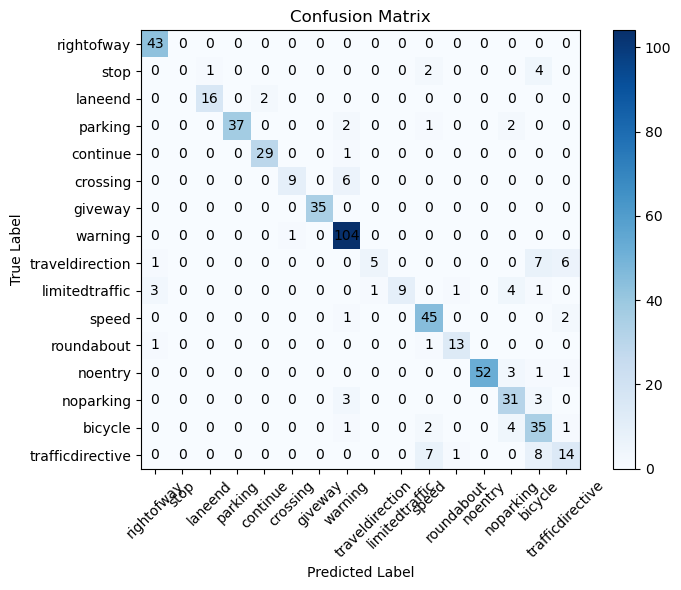

In [89]:
# Evaluate the shape model on test data
print("Performace Metrics of Optimised CNN Model for Sign on Test data after Feature Extraction:-")
sign_cm_cnn_edge_test = evaluate_model(sign_model_cnn_edge, X_test_sign_cnn_edge, y_test_sign,"CNN Model 5","Sign","Test",6);

# Visualise Confusion matrix
visualise_cm(sign_cm_cnn_edge_test, class_labels_sign)

# 9. Predicting Values on Collected Data using Final Optimised Model

In this step, we utilize the `final optimized model (Model 6)`, which was refined through a series of enhancements including batch normalization, regularization, dropout, padding, data augmentation, and edge extraction. The model's parameters have been meticulously tuned, adjusting layer numbers, layer sizes, activation functions, optimizers, and learning rates. Now, we apply this model to our collected shape and sign images to predict their classifications, leveraging the comprehensive optimization efforts undertaken to enhance the model's accuracy and robustness.

## 9.1 Predicting and Evaluating Labels for Shape data

In [90]:
# Evaluate the model on validation data
print("Performace Metrics of Optimised CNN Model for Shape on Collected Data:-")
shape_cm_cnn_edge_test_collected = evaluate_model(shape_model_cnn_aug, X_test_shape_collected, y_test_shape_collected_one_hot,"CNN Model 5","Shape","Collected",6);


Performace Metrics of Optimised CNN Model for Shape on Collected Data:-
Accuracy:  0.9456
Precision:  0.9468
Recall:  0.9456
F1 Score:  0.9404
Cohen's Kappa:  0.909


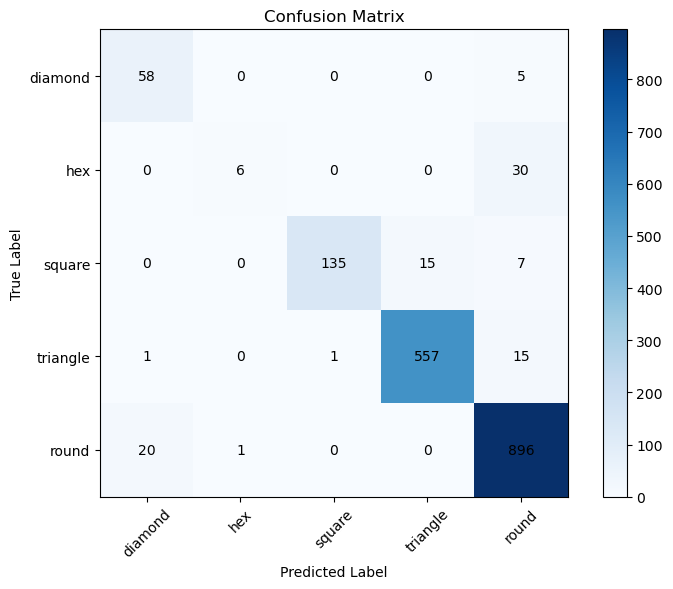

In [91]:
# Visualise Confusion matrix
visualise_cm(shape_cm_cnn_edge_test_collected, class_labels_shape)

## 9.2 Predicting and Evaluating Labels for Sign Data

Performace Metrics of Optimised CNN Model for Sign on Collected Data:-
Accuracy:  0.8065
Precision:  0.8413
Recall:  0.8065
F1 Score:  0.7761
Cohen's Kappa:  0.7756


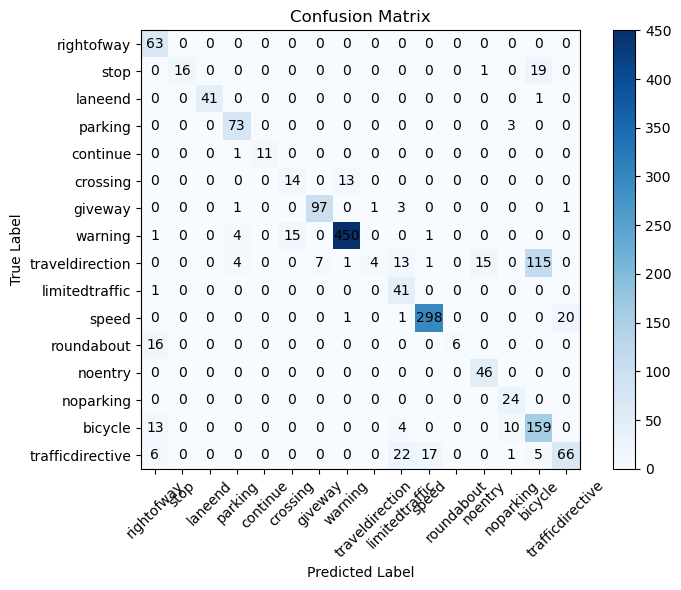

In [92]:
# Evaluate the shape model on test data
print("Performace Metrics of Optimised CNN Model for Sign on Collected Data:-")
sign_cm_cnn_edge_test_collected = evaluate_model(sign_model_cnn_aug, X_test_sign_collected, y_test_sign_collected_one_hot,"CNN Model 5","Sign","Collected",6);

# Visualise Confusion matrix
visualise_cm(sign_cm_cnn_edge_test_collected, class_labels_sign)


# 10. Model Evaluation Summary

In [93]:
results_df.head(30)

Model Name   Type EvaluationStage Model Level  Accuracy  Precision  \
0   MLP Baseline  Shape      Validation           1    0.7194     0.6961   
1   MLP Baseline  Shape            Test           1    0.7415     0.7190   
2   MLP Baseline   Sign      Validation           1    0.1865     0.0348   
3   MLP Baseline   Sign            Test           1    0.1865     0.0348   
4    CNN Model 1  Shape      Validation           2    0.4730     0.2237   
5    CNN Model 1  Shape            Test           2    0.4740     0.2246   
6    CNN Model 1   Sign      Validation           2    0.1865     0.0348   
7    CNN Model 1   Sign            Test           2    0.1865     0.0348   
8    CNN Model 2  Shape      Validation           3    0.9586     0.9603   
9    CNN Model 2  Shape            Test           3    0.9587     0.9480   
10   CNN Model 2   Sign      Validation           3    0.8597     0.8763   
11   CNN Model 2   Sign            Test           3    0.8828     0.8964   
12   CNN Model 3  Shape      Validation           4    0.8579     0.8758   
13   CNN Model 3  Shape            Test           4    0.8671     0.8685   
14   CNN Model 3   Sign      Validation           4    0.7762     0.8205   
15   CNN Model 3   Sign            Test           4    0.7798     0.8383   
16   CNN Model 4  Shape      Validation           5    0.8993     0.9040   
17   CNN Model 4  Shape            Test           5    0.9102     0.9029   
18   CNN Model 4   Sign      Validation           5    0.8330     0.8500   
19   CNN Model 4   Sign            Test           5    0.8508     0.8731   
20   CNN Model 5  Shape      Validation           6    0.9550     0.9448   
21   CNN Model 5  Shape            Test           6    0.9641     0.9529   
22   CNN Model 5   Sign      Validation           6    0.8579     0.8572   
23   CNN Model 5   Sign            Test           6    0.8472     0.8485   
24   CNN Model 5  Shape       Collected           6    0.9456     0.9468   
25   CNN Model 5   Sign       Collected           6    0.8065     0.8413   

    Recall  F1 Score  Cohen's Kappa  
0   0.7194    0.6694         0.5289  
1   0.7415    0.6836         0.5673  
2   0.1865    0.0586         0.0000  
3   0.1865    0.0586         0.0000  
4   0.4730    0.3038         0.0000  
5   0.4740    0.3048         0.0000  
6   0.1865    0.0586         0.0000  
7   0.1865    0.0586         0.0000  
8   0.9586    0.9546         0.9377  
9   0.9587    0.9525         0.9375  
10  0.8597    0.8507         0.8455  
11  0.8828    0.8788         0.8711  
12  0.8579    0.8620         0.7900  
13  0.8671    0.8628         0.8011  
14  0.7762    0.7713         0.7542  
15  0.7798    0.7814         0.7588  
16  0.8993    0.8976         0.8462  
17  0.9102    0.9039         0.8633  
18  0.8330    0.8276         0.8169  
19  0.8508    0.8447         0.8362  
20  0.9550    0.9489         0.9321  
21  0.9641    0.9580         0.9458  
22  0.8579    0.8493         0.8434  
23  0.8472    0.8349         0.8314  
24  0.9456    0.9404         0.9090  
25  0.8065    0.7761         0.7756

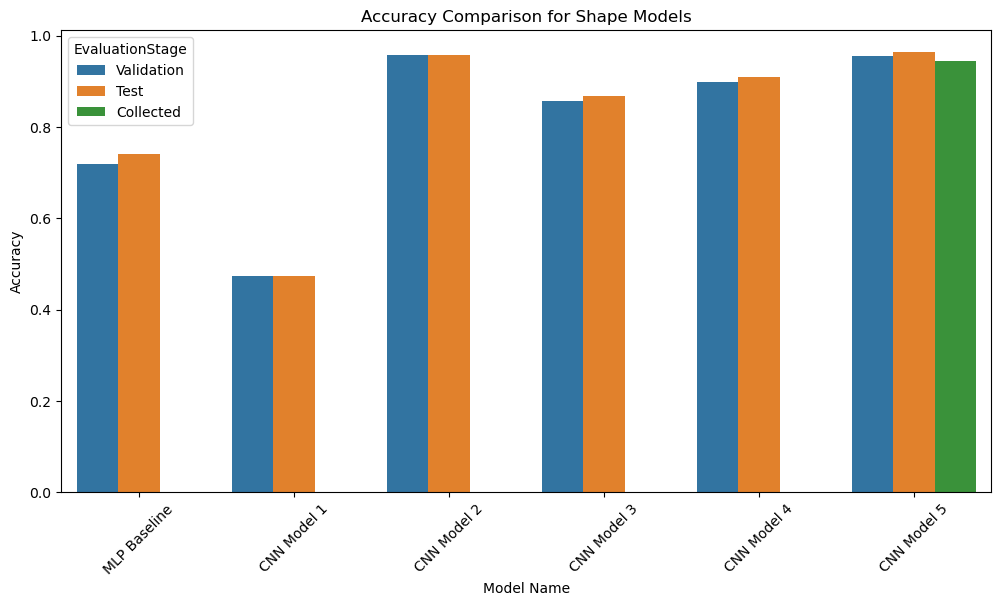

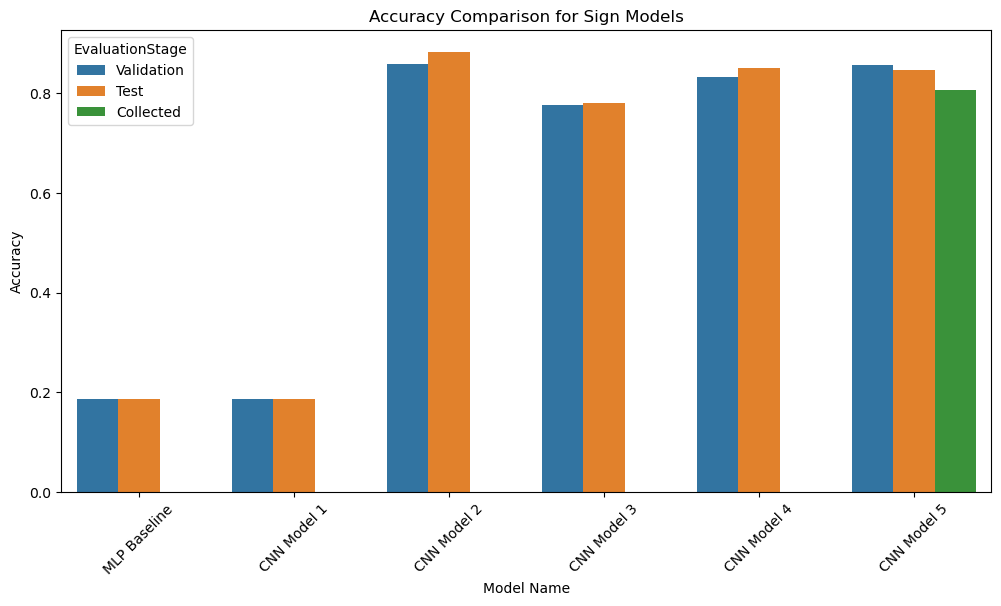

In [94]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model Name', y='Accuracy', hue='EvaluationStage', data=results_df[results_df['Type'].str.lower() == 'shape'])
plt.title('Accuracy Comparison for Shape Models')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model Name', y='Accuracy', hue='EvaluationStage', data=results_df[results_df['Type'].str.lower() == 'sign'])
plt.title('Accuracy Comparison for Sign Models')
plt.xticks(rotation=45)
plt.show()


# 11. Custom ResNet32-Inspired Neural Network for Image Classification 
# (Model 7)

This custom neural network is designed for image classification and draws inspiration from the ResNet50 architecture. ResNet (Residual Networks) is known for its ability to train very deep networks without the vanishing gradient problem, thanks to its residual blocks. Here, we have created a simpler version of ResNet50 that is computationally less demanding, making it suitable for smaller datasets and limited computational resources. The model is designed to handle grayscale images of size 28x28 and includes several key components and design principles from ResNet50, adapted to be computationally manageable.

## Explanation of the Architecture

### Identity Block
The identity block is a fundamental building block of ResNet. It allows the input to be passed through directly (via a shortcut connection) and added to the output of a series of convolutional layers. This helps in preserving the gradient during backpropagation, addressing the vanishing gradient problem, and enabling the training of deeper networks.

#### Structure:
- **First Convolution Layer**: 1x1 convolution to reduce the number of filters.
- **Second Convolution Layer**: fxf convolution to process the features.
- **Third Convolution Layer**: Another 1x1 convolution to restore the original number of filters.
- **Shortcut Connection**: The original input (shortcut) is added to the output of the convolution layers.
- **Activation**: ReLU activation is applied after the addition to introduce non-linearity.

### Convolutional Block
The convolutional block is another crucial component of ResNet. It is similar to the identity block but includes a convolution operation in the shortcut path to change the dimensions of the input to match the output. This allows for downsampling and expanding the depth of the network.

#### Structure:
- **First Convolution Layer**: 1x1 convolution with stride s to reduce the number of filters and dimensions.
- **Second Convolution Layer**: fxf convolution to process the features.
- **Third Convolution Layer**: Another 1x1 convolution to restore the original number of filters.
- **Shortcut Path**: Convolution with stride s to match dimensions.
- **Addition and Activation**: The shortcut is added to the main path output, followed by ReLU activation.

### Create Model
The `create_minet` function defines the overall structure of the model. It includes multiple stages, each with convolutional and identity blocks to extract features at different levels of abstraction. The network ends with global average pooling and dense layers for classification.

#### Structure:
1. **Input Layer**: Defines the input shape for grayscale images (28x28x1).
2. **Zero-Padding**: Adds padding to maintain spatial dimensions.
3. **Initial Convolution and Pooling**: The first stage includes a large convolutional layer followed by max pooling to downsample the image.
4. **Subsequent Stages**: Each stage consists of one convolutional block and one or more identity blocks, progressively increasing the depth and complexity.
5. **Global Average Pooling**: Reduces the dimensions before the fully connected layers.
6. **Fully Connected Layers**: Includes dense layers with dropout for regularization.
7. **Output Layer**: Softmax layer to output class probabilities.

### Explanation of Adaptations
- **Reduced Number of Layers**: The model has fewer layers compared to ResNet50 to reduce computational complexity.
- **Dropout Layers**: Dropout layers are added to prevent overfitting.
- **Global Average Pooling**: This layer is used instead of flattening, which reduces the number of parameters and helps in generalization.
- **Simplified Blocks**: Each stage includes only a few blocks, balancing between model depth and computational feasibility.

This custom model retains the essential elements of the ResNet architecture, such as residual connections and batch normalization, but adapts them to a smaller scale suitable for limited computational resources. It is designed to handle smaller input sizes and fewer parameters, making it practical for use cases where computational resources are a constraint. The model should perform well on tasks like image classification for smaller datasets.

In [95]:
def identity_block(X, filters, f):

    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, filters, f, s=2):

    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    
    # Shortcut path
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


def create_minet(num_classes):
    # Define input layer
    inputs = Input(shape=(28, 28, 1))
    
    # Zero-padding
    X = ZeroPadding2D((3, 3))(inputs)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, filters=[64, 64, 256], f=3, s=1)
    X = identity_block(X, filters=[64, 64, 256], f=3)
    
    # Stage 3
    X = convolutional_block(X, filters=[64, 64, 256], f=3, s=1)
    X = identity_block(X, filters=[64, 64, 256], f=3)
    
    # Stage 4
    X = convolutional_block(X, filters=[128, 128, 512], f=3, s=1)
    X = identity_block(X, filters=[128, 128, 512], f=3)

    # Stage 5
    X = convolutional_block(X, filters=[128, 128, 512], f=3, s=1)
    X = identity_block(X, filters=[128, 128, 512], f=3)
    
    # Add another convolutional layer before GlobalAveragePooling2D
    X = Conv2D(512, (3, 3), padding='same')(X)
    X = BatchNormalization(axis=3, name='bn_conv2')(X)
    X = Activation('relu')(X)
    
    X = GlobalAveragePooling2D()(X)
    
    # Fully connected layers
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.4)(X)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(X)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    opt = Adam(learning_rate=0.01)  # Initial learning rate
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
                            

## 11.1 Inspired Model Training on Shape Data

In [96]:
minet_shape = create_minet(num_classes_shape)

minet_shape.summary()

Model: "functional_131"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34, 1) │          0 │ input_layer_14[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 14, 14,    │      3,200 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 14, 14,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 14, 14,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_36    │ (None, 6, 6, 64)  │          0 │ activation_30[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 6, 6, 64)  │      4,160 │ max_pooling2d_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 6, 6, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 6, 6, 64)  │     36,928 │ activation_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 6, 6, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 6, 6, 256) │     16,640 │ activation_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 6, 6, 256) │     16,640 │ max_pooling2d_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 256) │      1,024 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 256) │      1,024 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 6, 6, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 6, 6, 256) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                 

 Total params: 4,285,061 (16.35 MB)

 Trainable params: 4,271,621 (16.29 MB)

 Non-trainable params: 13,440 (52.50 KB)

In [97]:
# Define the EarlyStopping callback
early_stopping_shape = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=5,         # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore the weights from the epoch with the best value of the monitored metric


# Train the model
# Fit the model with early stopping
history_minet_shape = minet_shape.fit(X_aug_shape_cnn_edge, y_aug_shape,
                           batch_size=50,
                           epochs=10,
                           validation_data=(X_val_shape_cnn_edge, y_val_shape),
                           callbacks=[early_stopping_shape])

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - accuracy: 0.4335 - loss: 1.5985 - val_accuracy: 0.4730 - val_loss: 118.1808
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 240ms/step - accuracy: 0.4690 - loss: 1.2562 - val_accuracy: 0.6457 - val_loss: 0.9612
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 232ms/step - accuracy: 0.5343 - loss: 1.1434 - val_accuracy: 0.5989 - val_loss: 0.8644
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.5410 - loss: 1.1139 - val_accuracy: 0.6781 - val_loss: 1.0415
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 238ms/step - accuracy: 0.5465 - loss: 1.0753 - val_accuracy: 0.6421 - val_loss: 1.9261
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.5594 - loss: 1.0793 - val_accuracy: 0.4335 - val_loss: 3.8551
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.5741 - loss: 1.0434 - val_accuracy: 0.8004 - val_loss: 0.6057
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.5807 - loss:

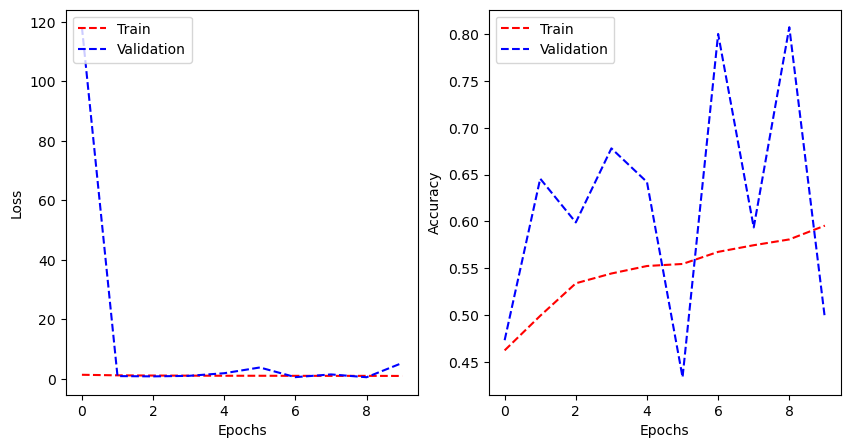

In [98]:
# Plot learning curves using the custom function
plot_learning_curve(history_minet_shape.history['loss'], history_minet_shape.history['val_loss'],
                    history_minet_shape.history['accuracy'], history_minet_shape.history['val_accuracy'],
                    metric_name='Accuracy')

In [99]:
# Evaluate the shape model on test data
print("Performance Metrics of ResNet32 Model for Shape on Validation Data:-")
shape_cm_minet_val = evaluate_model(minet_shape, X_val_shape_cnn_edge, y_val_shape,"ResNet32 (Inspired ResNet50)","Shape","Validation",7)

Performance Metrics of ResNet32 Model for Shape on Validation Data:-
Accuracy:  0.8076
Precision:  0.7957
Recall:  0.8076
F1 Score:  0.7964
Cohen's Kappa:  0.7116


Performance Metrics of ResNet32 Model for Shape on Test Data:-
Accuracy:  0.7864
Precision:  0.7665
Recall:  0.7864
F1 Score:  0.7722
Cohen's Kappa:  0.6774


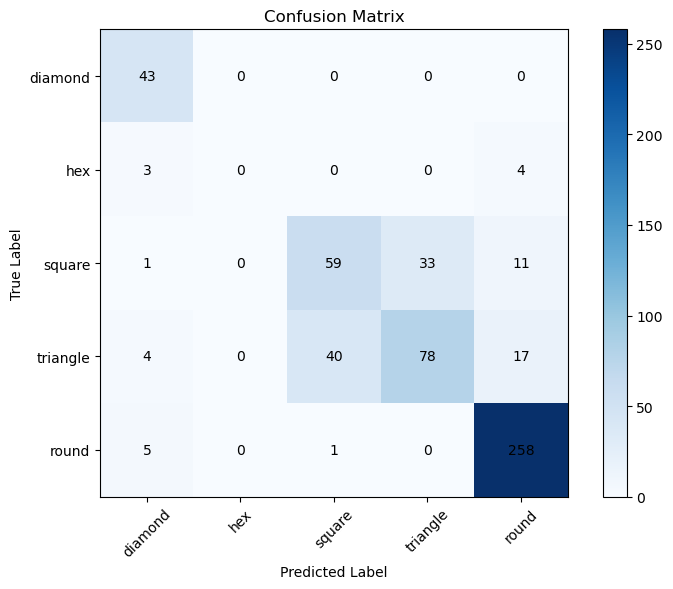

In [100]:
# Evaluate the shape model on val data
print("Performance Metrics of ResNet32 Model for Shape on Test Data:-")
shape_cm_minet_test = evaluate_model(minet_shape, X_test_shape_cnn_edge, y_test_shape,"ResNet32 (Inspired ResNet50)","Shape","Test",7)

# Visualise Confusion matrix
visualise_cm(shape_cm_minet_test, class_labels_shape)

Performace Metrics of ResNet32 Model for Shape on Collected Test:-
Accuracy:  0.5249
Precision:  0.2755
Recall:  0.5249
F1 Score:  0.3614
Cohen's Kappa:  0.0


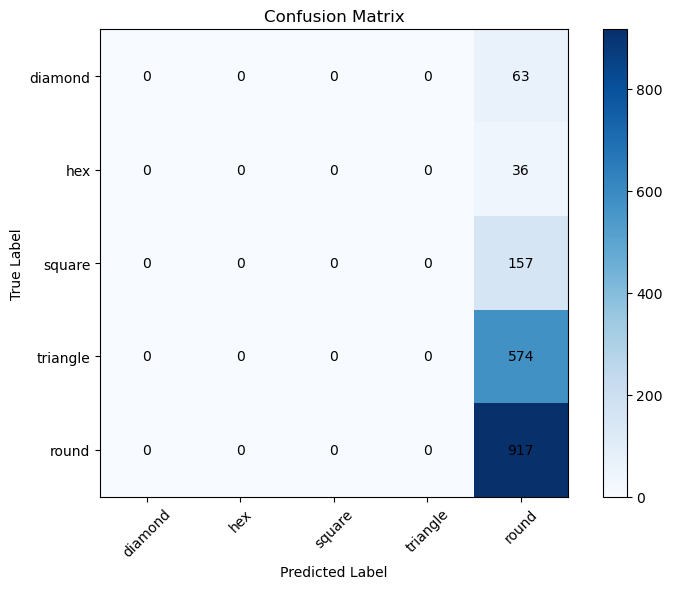

In [101]:
# Evaluate the model on collected test data
print("Performace Metrics of ResNet32 Model for Shape on Collected Test:-")
shape_minet_test_collected = evaluate_model(minet_shape, X_test_shape_collected, y_test_shape_collected_one_hot,"ResNet32 (Inspired ResNet50)","Shape","Collected",7);

# Visualise Confusion matrix
visualise_cm(shape_minet_test_collected, class_labels_shape)

## 11.2 Inspired Model Training on Sign Data

In [102]:
minet_sign = create_minet(num_classes_sign)

minet_sign.summary()

Model: "functional_133"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 34, 34, 1) │          0 │ input_layer_15[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 14, 14,    │      3,200 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 14, 14,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 14, 14,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_37    │ (None, 6, 6, 64)  │          0 │ activation_56[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 6, 6, 64)  │      4,160 │ max_pooling2d_37… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 6, 6, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 6, 6, 64)  │     36,928 │ activation_57[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 6, 6, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 6, 6, 256) │     16,640 │ activation_58[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 6, 6, 256) │     16,640 │ max_pooling2d_37… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 256) │      1,024 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 256) │      1,024 │ conv2d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 6, 6, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 6, 6, 256) │          0 │ add_8[0][0]       │
│ (Activation)        │                   │            │                 

 Total params: 4,286,480 (16.35 MB)

 Trainable params: 4,273,040 (16.30 MB)

 Non-trainable params: 13,440 (52.50 KB)

In [103]:
# Define the EarlyStopping callback
early_stopping_sign = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=5,         # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore the weights from the epoch with the best value of the monitored metric

# Train the model
# Fit the model with early stopping
history_minet_sign = minet_sign.fit(X_aug_sign_cnn_edge, y_aug_sign,
                          batch_size=50,
                          epochs=10,
                          validation_data=(X_val_sign_cnn_edge, y_val_sign),
                          callbacks=[early_stopping_sign])


Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 38s 216ms/step - accuracy: 0.1615 - loss: 2.8779 - val_accuracy: 0.1865 - val_loss: 2.6092
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - accuracy: 0.1890 - loss: 2.5500 - val_accuracy: 0.1865 - val_loss: 2.6396
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 39s 249ms/step - accuracy: 0.2123 - loss: 2.4885 - val_accuracy: 0.2842 - val_loss: 4.2026
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 220ms/step - accuracy: 0.2234 - loss: 2.4062 - val_accuracy: 0.2220 - val_loss: 2.5397
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 220ms/step - accuracy: 0.2431 - loss: 2.3488 - val_accuracy: 0.3393 - val_loss: 2.0588
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 33s 214ms/step - accuracy: 0.2437 - loss: 2.3203 - val_accuracy: 0.3055 - val_loss: 3.0746
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 228ms/step - accuracy: 0.2509 - loss: 2.2943 - val_accuracy: 0.4654 - val_loss: 1.5421
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 33s 215ms/step - accuracy: 0.2579 - loss: 2

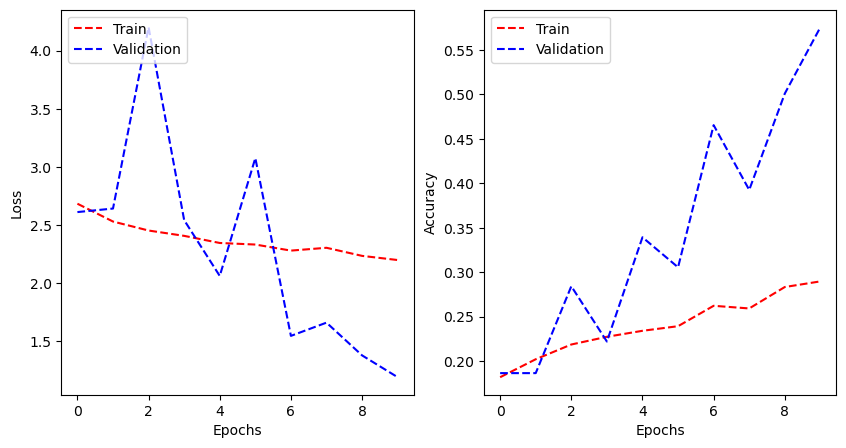

In [104]:
# Plot learning curves using the custom function
plot_learning_curve(history_minet_sign.history['loss'], history_minet_sign.history['val_loss'],
                    history_minet_sign.history['accuracy'], history_minet_sign.history['val_accuracy'],
                    metric_name='Accuracy')

In [105]:
# Evaluate the sign model on test data
print("Performance Metrics of MiNet Model for Sign on Test Data:-")
sign_cm_minet_val = evaluate_model(minet_sign, X_val_sign_cnn_edge, y_val_sign,"ResNet32 (Inspired ResNet50)","Sign","Validation",7)

Performance Metrics of MiNet Model for Sign on Test Data:-
Accuracy:  0.5755
Precision:  0.4894
Recall:  0.5755
F1 Score:  0.4948
Cohen's Kappa:  0.5266


Performance Metrics of MiNet Model for Sign on Test Data:-
Accuracy:  0.5826
Precision:  0.4984
Recall:  0.5826
F1 Score:  0.4967
Cohen's Kappa:  0.5339


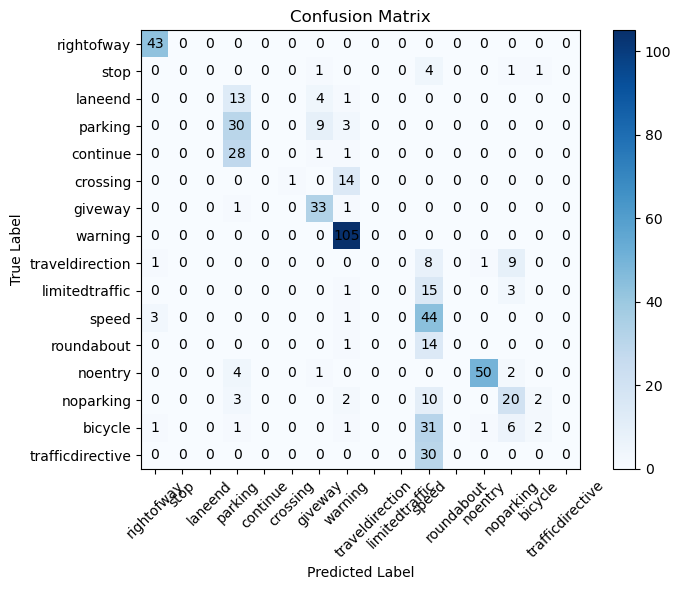

In [106]:
# Evaluate the sign model on test data
print("Performance Metrics of MiNet Model for Sign on Test Data:-")
sign_cm_minet_test = evaluate_model(minet_sign, X_test_sign_cnn_edge, y_test_sign,"ResNet32 (Inspired ResNet50)","Sign","Test",7)

# Visualise Confusion matrix
visualise_cm(sign_cm_minet_test, class_labels_sign)

Performace Metrics of ResNet32 Model for Sign on Collected Test:-
Accuracy:  0.2696
Precision:  0.0727
Recall:  0.2696
F1 Score:  0.1145
Cohen's Kappa:  0.0


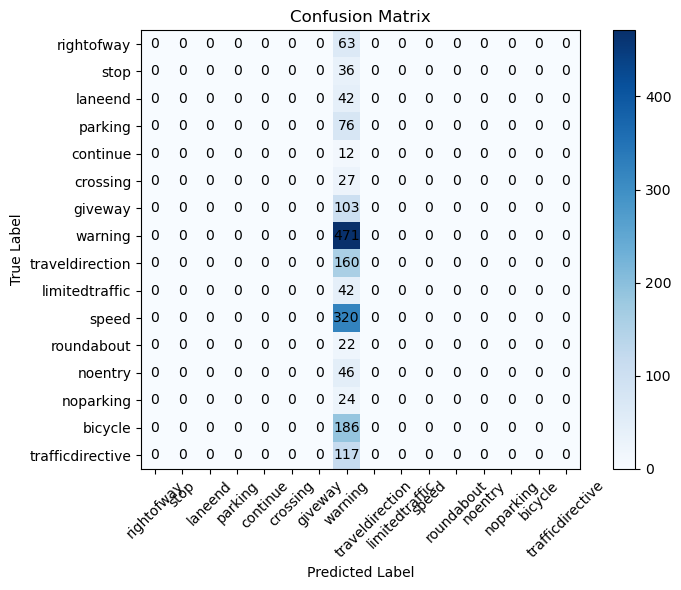

In [107]:
# Evaluate the model on collected test data
print("Performace Metrics of ResNet32 Model for Sign on Collected Test:-")
sign_minet_test_collected = evaluate_model(minet_sign, X_test_sign_collected, y_test_sign_collected_one_hot,"ResNet32 (Inspired ResNet50)","Sign","Collected",7);

# Visualise Confusion matrix
visualise_cm(sign_minet_test_collected, class_labels_sign)

# 12 Pre Trained ResNet 50 (Model 8)

In [108]:
# Function to create ResNet50 model
def create_resnet50_model(num_classes):
    # Load ResNet50 model without the top layer and set input shape to (32, 32, 1)
    base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 1))
    
    # Add zero padding to increase input size to 32x32
    inputs = Input(shape=(28, 28, 1))
    x = ZeroPadding2D(padding=((2, 2), (2, 2)))(inputs)  # Add 2 pixels of padding to all sides
    x = base_model(x)  # Pass through the ResNet50 base model
    
    # Add your own top layers
    x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce spatial dimensions
    x = Dense(128, activation='relu')(x)  # Add a dense layer
    outputs = Dense(num_classes, activation='softmax')(x)  # Final softmax layer for classification
    
    # Create your custom model
    resnet_model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    resnet_model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

    return resnet_model


In [109]:
# Preparing data for ResNet50
y_aug_shape_one_hot = to_categorical(y_aug_shape_cnn, num_classes=5)
y_val_shape_one_hot = to_categorical(y_val_shape_mlp, num_classes=5)
y_test_shape_one_hot = to_categorical(y_test_shape_mlp, num_classes=5)
y_test_shape_collected_one_hot = to_categorical(y_test_shape_collected, num_classes=5)

y_aug_sign_one_hot = to_categorical(y_aug_sign_cnn, num_classes=16)
y_val_sign_one_hot = to_categorical(y_val_sign_mlp, num_classes=16)
y_test_sign_one_hot = to_categorical(y_test_sign_mlp, num_classes=16)
y_test_sign_collected_one_hot = to_categorical(y_test_sign_collected, num_classes=16)

## 12.1 ResNet50 Model Training on Shape Data

In [110]:
resnet_shape = create_resnet50_model(num_classes_shape)

resnet_shape.summary()

Model: "functional_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 32, 32, 1)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,581,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,844,357 (90.96 MB)

 Trainable params: 23,791,237 (90.76 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [111]:
# Train the model
history_resnet_shape = resnet_shape.fit(X_aug_shape_cnn_edge, y_aug_shape_one_hot,
                       batch_size=100,
                       epochs=10,
                       validation_data=(X_val_shape_cnn_edge, y_val_shape_one_hot),
                       callbacks=[early_stopping_shape])

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.3964 - loss: 4.5890 - val_accuracy: 0.4730 - val_loss: 1591638.7500
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4795 - loss: 1.2288 - val_accuracy: 0.4730 - val_loss: 2978.2363
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5136 - loss: 1.2166 - val_accuracy: 0.4766 - val_loss: 1.1701
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5279 - loss: 1.2084 - val_accuracy: 0.6259 - val_loss: 0.9748
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5383 - loss: 1.1299 - val_accuracy: 0.6601 - val_loss: 0.8171


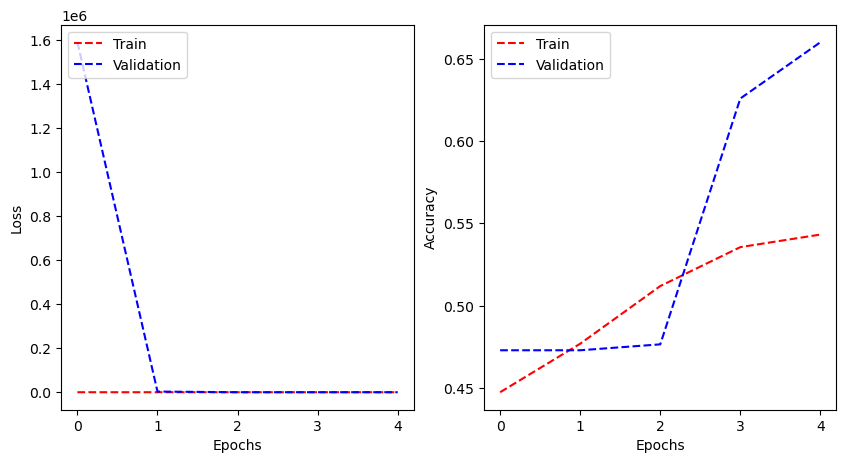

In [112]:
# Plot learning curves using the custom function
plot_learning_curve(history_resnet_shape.history['loss'], history_resnet_shape.history['val_loss'],
                    history_resnet_shape.history['accuracy'], history_resnet_shape.history['val_accuracy'],
                    metric_name='Accuracy')

In [113]:
# Evaluate the shape model on test data
print("Performance Metrics of ResNet50 Model for Shape on Validation Data:-")
shape_cm_resnet_val = evaluate_model(resnet_shape, X_val_shape_cnn_edge, y_val_shape_one_hot,"ResNet50","Shape","Validation",8)

Performance Metrics of ResNet50 Model for Shape on Validation Data:-
Accuracy:  0.473
Precision:  0.2237
Recall:  0.473
F1 Score:  0.3038
Cohen's Kappa:  0.0


Performance Metrics of ResNet50 Model for Test on Validation Data:-
Accuracy:  0.474
Precision:  0.2246
Recall:  0.474
F1 Score:  0.3048
Cohen's Kappa:  0.0


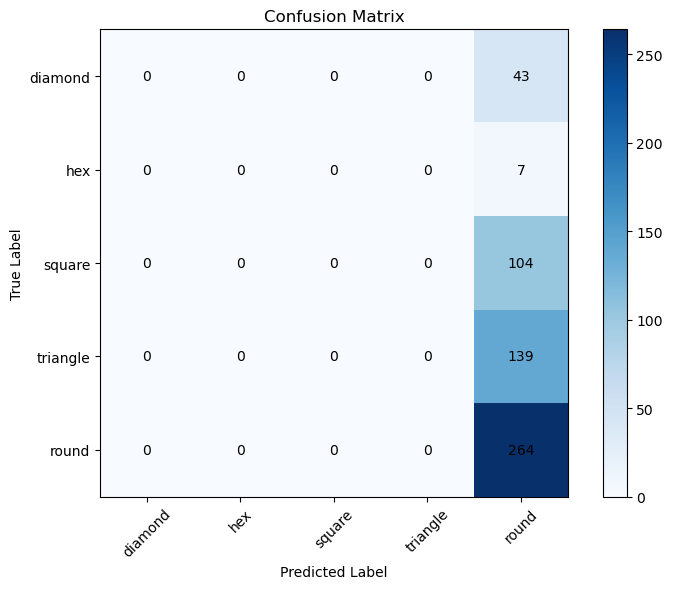

In [114]:
# Evaluate the shape model on val data
print("Performance Metrics of ResNet50 Model for Test on Validation Data:-")
shape_cm_resnet_test = evaluate_model(resnet_shape, X_test_shape_cnn_edge, y_test_shape_one_hot,"ResNet50","Shape","Test",8)

# Visualise Confusion matrix
visualise_cm(shape_cm_resnet_test, class_labels_shape)

Performace Metrics of ResNet50 Model for Shape on Collected Test:-
Accuracy:  0.5249
Precision:  0.2755
Recall:  0.5249
F1 Score:  0.3614
Cohen's Kappa:  0.0


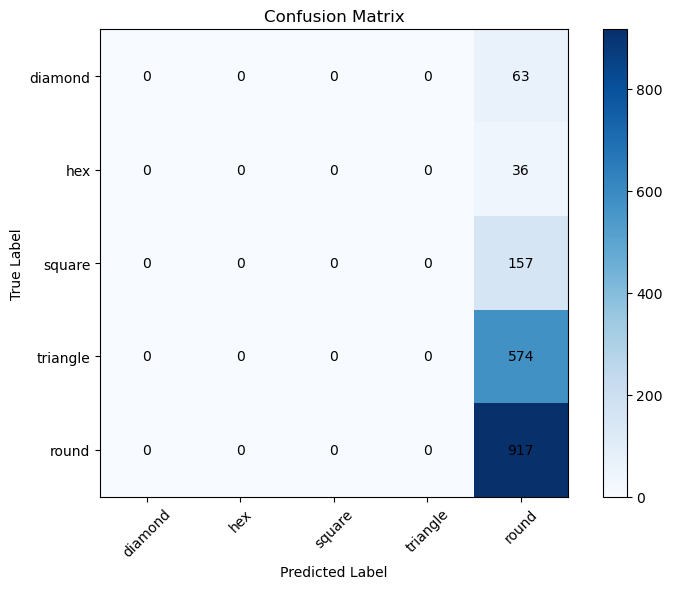

In [115]:
# Evaluate the model on collected test data
print("Performace Metrics of ResNet50 Model for Shape on Collected Test:-")
shape_resnet_test_collected = evaluate_model(resnet_shape, X_test_shape_collected, y_test_shape_collected_one_hot,"ResNet50","Shape","Collected",8);

# Visualise Confusion matrix
visualise_cm(shape_resnet_test_collected, class_labels_shape)

## 12.2 ResNet50 Model Training on Sign Data

In [116]:
resnet_sign = create_resnet50_model(num_classes_sign)

resnet_sign.summary()

Model: "functional_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 32, 32, 1)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,581,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,845,776 (90.96 MB)

 Trainable params: 23,792,656 (90.76 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [117]:
# Train the model
history_resnet_sign = resnet_sign.fit(X_aug_sign_cnn_edge, y_aug_sign_one_hot,
                       batch_size=100,
                       epochs=10,
                       validation_data=(X_val_sign_cnn_edge, y_val_sign_one_hot),
                       callbacks=[early_stopping_sign])

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.1355 - loss: 6.3895 - val_accuracy: 0.1865 - val_loss: 2.6898
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.1766 - loss: 2.5854 - val_accuracy: 0.1528 - val_loss: 2.7305
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.1891 - loss: 2.5566 - val_accuracy: 0.2060 - val_loss: 2.3490
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2184 - loss: 2.4508 - val_accuracy: 0.3020 - val_loss: 2.5628
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2454 - loss: 2.4062 - val_accuracy: 0.3996 - val_loss: 1.8546


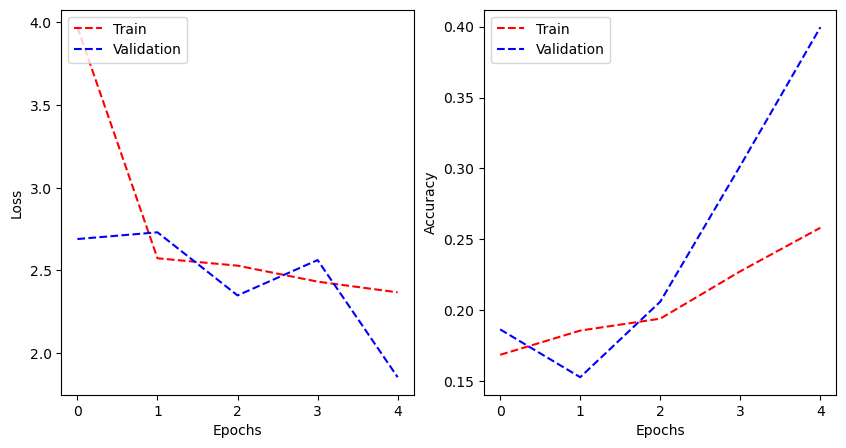

In [118]:
# Plot learning curves using the custom function
plot_learning_curve(history_resnet_sign.history['loss'], history_resnet_sign.history['val_loss'],
                    history_resnet_sign.history['accuracy'], history_resnet_sign.history['val_accuracy'],
                    metric_name='Accuracy')

In [119]:
# Evaluate the sign model on test data
print("Performance Metrics of ResNet50 Model for sign on Validation Data:-")
sign_cm_resnet_val = evaluate_model(resnet_sign, X_val_sign_cnn_edge, y_val_sign_one_hot,"ResNet50","Sign","Validation",8)

Performance Metrics of ResNet50 Model for sign on Validation Data:-
Accuracy:  0.1865
Precision:  0.0348
Recall:  0.1865
F1 Score:  0.0586
Cohen's Kappa:  0.0


Performance Metrics of ResNet50 Model for Test on Validation Data:-
Accuracy:  0.1865
Precision:  0.0348
Recall:  0.1865
F1 Score:  0.0586
Cohen's Kappa:  0.0


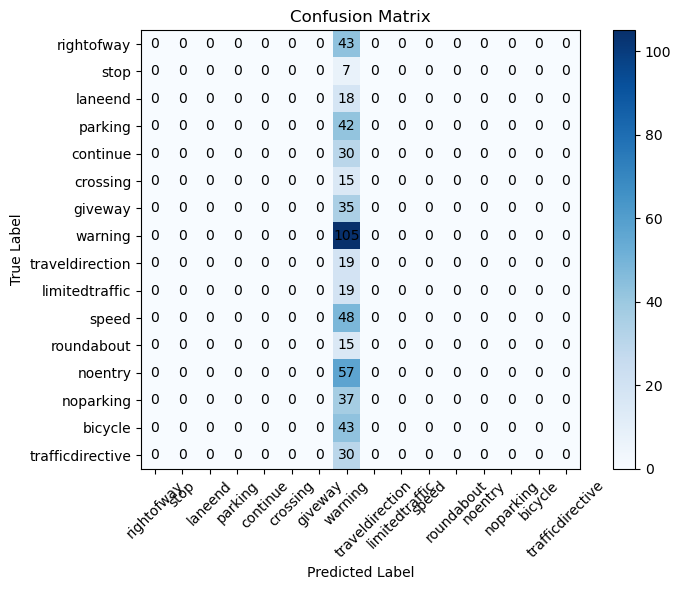

In [120]:
# Evaluate the sign model on test data
print("Performance Metrics of ResNet50 Model for Test on Validation Data:-")
sign_cm_resnet_test = evaluate_model(resnet_sign, X_test_sign_cnn_edge, y_test_sign_one_hot,"ResNet50","Sign","Test",8)

# Visualise Confusion matrix
visualise_cm(sign_cm_resnet_test, class_labels_sign)

Performace Metrics of ResNet50 Model for Sign on Collected Test:-
Accuracy:  0.2696
Precision:  0.0727
Recall:  0.2696
F1 Score:  0.1145
Cohen's Kappa:  0.0


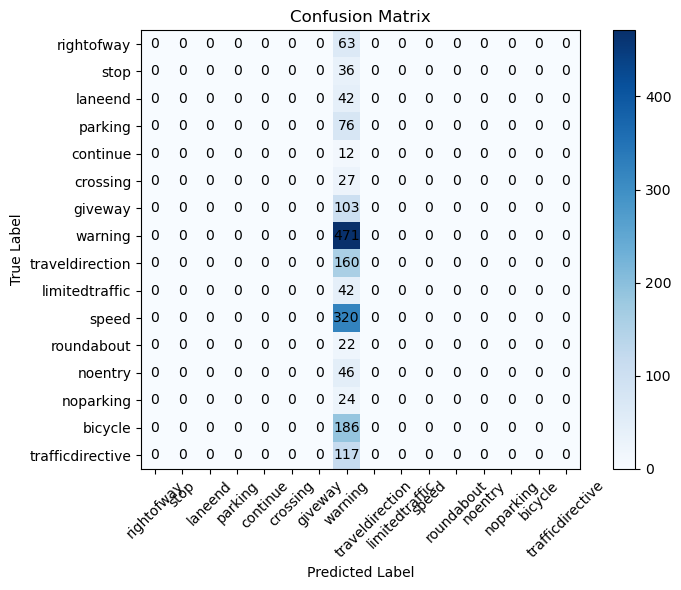

In [121]:
# Evaluate the model on collected test data
print("Performace Metrics of ResNet50 Model for Sign on Collected Test:-")
sign_resnet_test_collected = evaluate_model(resnet_sign, X_test_sign_collected, y_test_sign_collected_one_hot,"ResNet50","Sign","Collected",8);

# Visualise Confusion matrix
visualise_cm(sign_resnet_test_collected, class_labels_sign)

# Visualization:

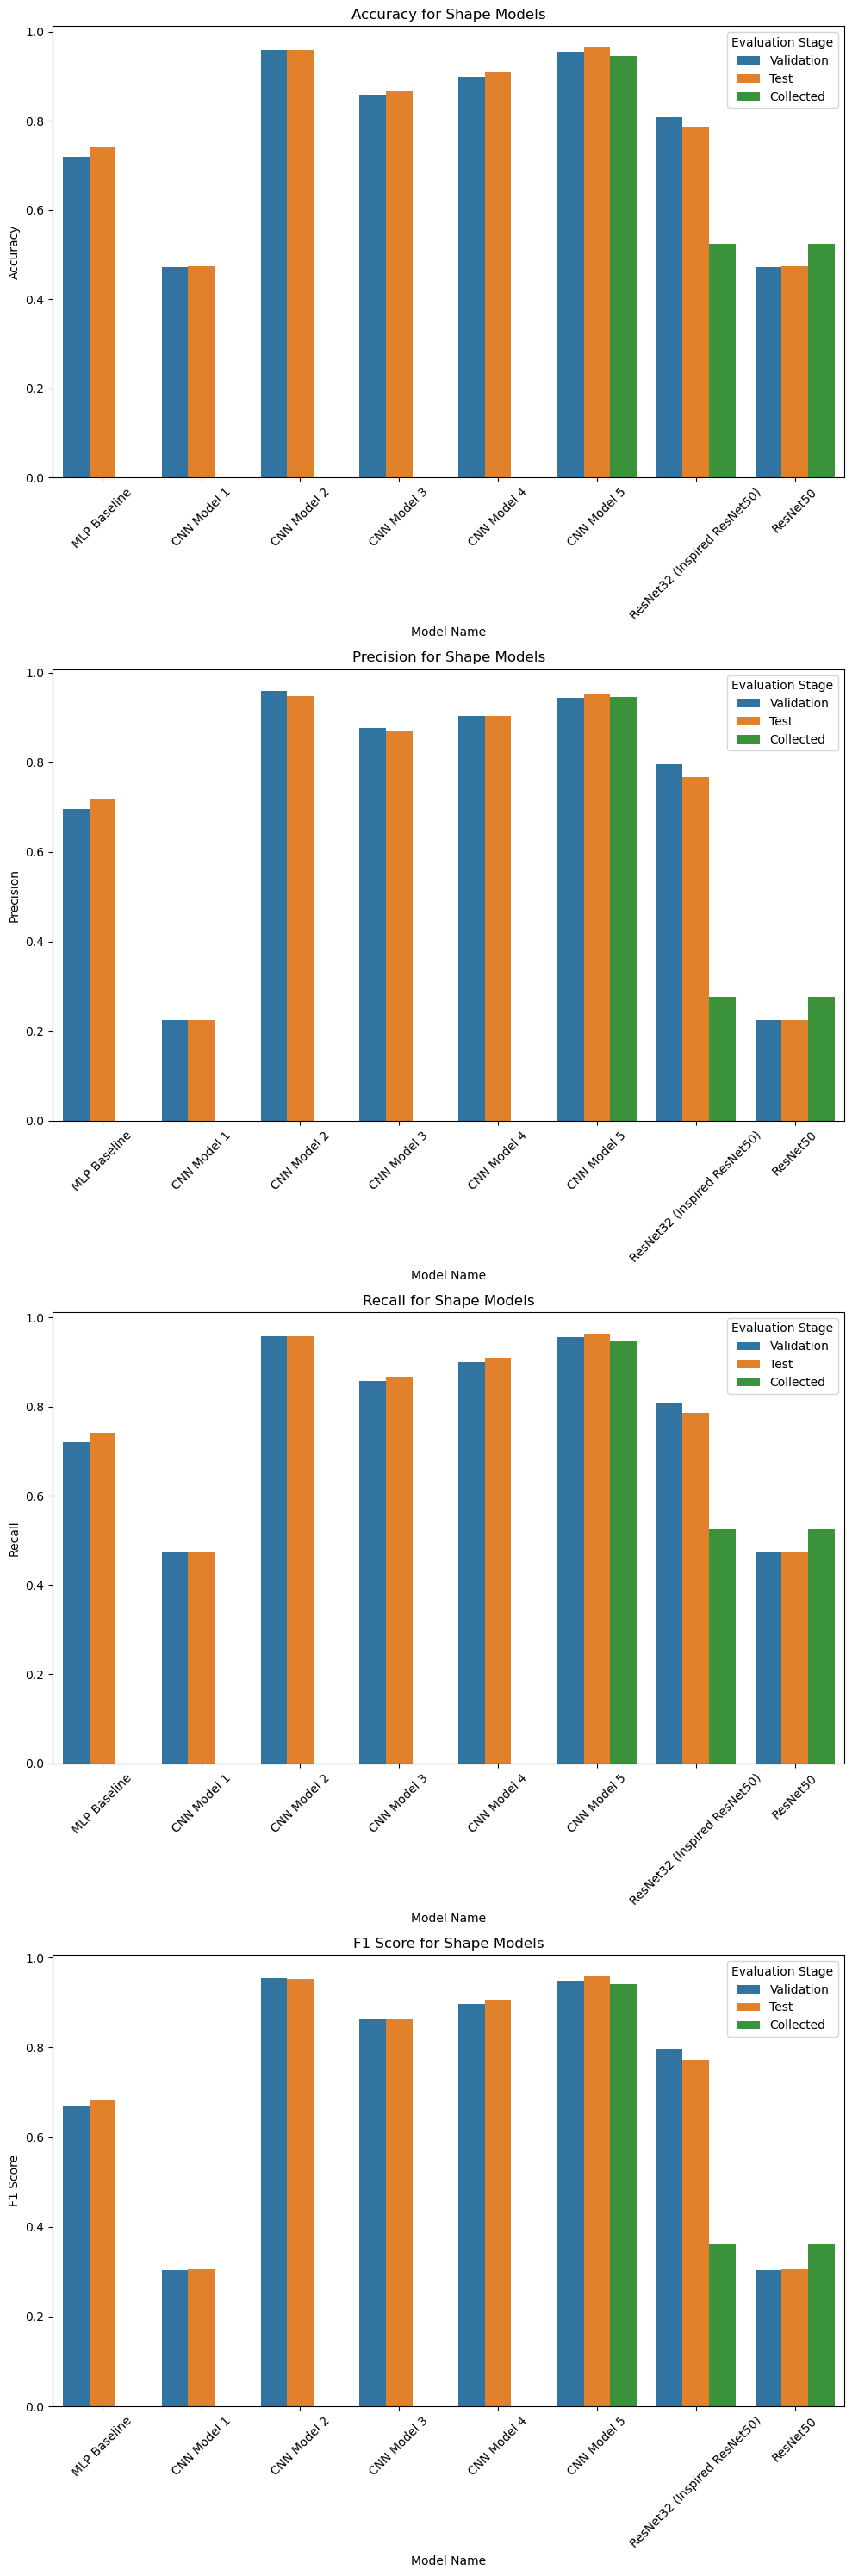

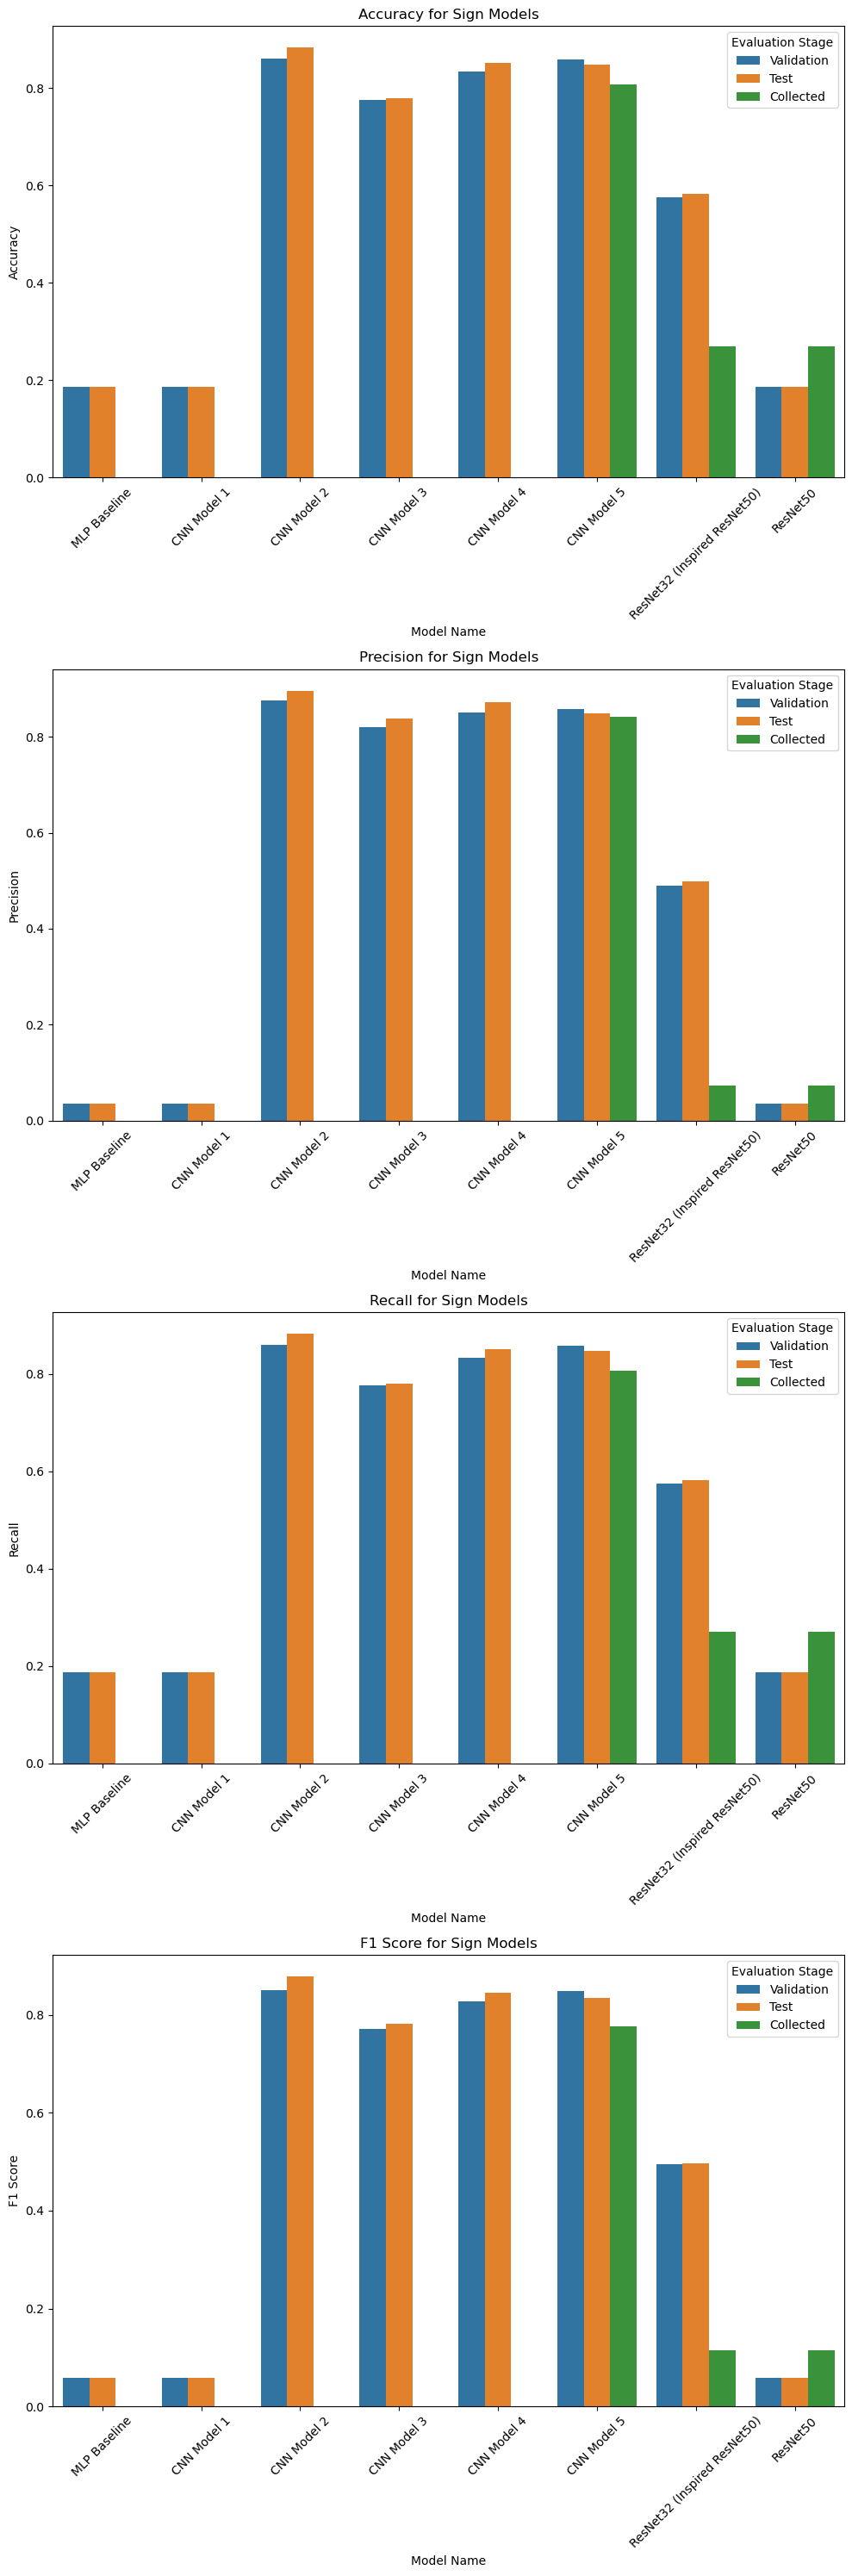

In [122]:
# Separate the data
shape_df = results_df[results_df['Type'] == 'Shape']
sign_df = results_df[results_df['Type'] == 'Sign']

# Function to plot evaluation metrics
def plot_metrics(df, model_type):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    num_metrics = len(metrics)
    
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(10, 30))
    
    for i, metric in enumerate(metrics):
        sns.barplot(ax=axes[i], x='Model Name', y=metric, hue='EvaluationStage', data=df)
        axes[i].set_title(f'{metric} for {model_type} Models')
        axes[i].set_xlabel('Model Name')
        axes[i].set_ylabel(metric)
        axes[i].legend(title='Evaluation Stage')
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot for Shape
plot_metrics(shape_df, 'Shape')

# Plot for Sign
plot_metrics(sign_df, 'Sign')
